In [1]:
import os
import sys

cwd0 = './config/'
sys.path.append(cwd0)

import visualID_Eng as vID
from visualID_Eng import color
vID.init(cwd0)

**Start at:** Sunday 26 November 2023, 13:28:53  
**Hostname:** zarko (Linux)

<p style="text-align: center"><img width="800px" src="./config/svg/PytChemBanner.svg" style="margin-left:auto; margin-right:auto"/></p>


# TCCM Homework:<br>**Quality rating of red wines by logistic regression**

<div class="intro">
    
<p style="text-align: center"><img width="650px" src="./config/svg/vinho-verde-header.jpg" style="margin-left:auto; margin-right:auto" id="img_vinho_verde"></p>
<br>

1. The purpose of this project is to **predict the quality** of Portuguese Vinho Verde wines based on their **physicochemical components**. The intent is to **replace a panel of wine tasters with an artificial neural network**.

2. Two **datasets** (one for white wines and the other for red wines) are downloadable on the [UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/wine+quality). The input variables (descriptors) are
- fixed acidity
- volatile acidity
- citric acid
- residual sugar
- chlorides
- free sulfur dioxide
- total sulfur dioxide
- density
- pH
- sulphates
- alcohol

Whereas the output variable, ***i.e.* the target**, is a 0 to 10 quality score, based on sensory data

3. **Bibliography**. There are two main references:
- An [original paper](https://doi.org/10.1016/j.dss.2009.05.016): Modeling wine preferences by data mining from physicochemical properties (**2009**), by Paulo Cortez, António Cerdeira, Fernando Almeida, Telmo Matos, José Reis, *Decision Support Systems* **47**: 547-553
- A [Wine Project github repository](https://github.com/kmspitzer/final-wineproject), at the core of the [Wine Quality website](https://ucsd-winequality.herokuapp.com/). Authors explored several classifiers: K Nearest Neighbors, Decision Tree, Random Forest, Random Forest Regressor, Stochastic Gradient Descent, Support Vector Classification, Linear Support Vector Classification, AdaBoost Classifier, Gradient Boost Classifier, XGB Classifier, and obtained 69% to 95% performance, the highest being from the Random Forest Regression, Random Forest, and XGBoost models.

Some useful pieces of codes will be found on the previous website as well as on the present PytChem repository. If you analyze the ML notebooks carefully, you will see that some pieces of code such as automatic one-hot encoding etc... are available, although they might have not been used during the talktorials (see the [DS4B-Appendix.ipynb notebook](./DS4B-Appendix.ipynb) and the [tools4PytChem.py scripts](./config/tools4PytChem.py))

4. **Mandatory implementation**.
- The code will be developed in Python, in **this Jupyter notebook**, using mainly the Keras and Tensorflow ML libraries, although some ML SciKit Learn tools can also be used, if necessary.
- It will be commented both using **Markdown cells** and **Python block comments or inline comments**.
- No separate report is required, the **final present notebook** will be used both to evaluate the code and to explain the purpose of each section and how the results should be analyzed.
- Particular attention will be paid to the **organization of the notebook**: use headers, ordered or unordered list of items, tables, mathematical formulas, hyperlinks, images, ....
- As done in the [Wine Project](https://github.com/kmspitzer/final-wineproject), **data will be cleaned and prepared**. A correlation matrix will plotted. You will do that separately for white and red wines. It could be interesting - or not -  to build a database mixing red and white wines, with a 12th descriptor for the wine color.
- You will try either a **simple ANN** and a **deep learning approach**. In addition to the accuracy of each tested ANN architecture, a **confusion matrix** would be helpful to better assess their performance.
- The numerical stability of the best model will be assessed using a **5-fold cross validation**.
</div>


## Introduction

<div class='intro'>
The problem we have here is ordinal classification problem. We need to predict the score of wine based on some features. As the score is integer from 0-10, this is a classification problem, we have 11 distinct classes. The classes are ordered, and there is sense of distance between classes. Therefore, this it would be smarter to approch this from the perspective of ordinal classification. One simple way (but in no means the only way) to handle this is to use regression and quality scores as numerical targets, and implement a decision function that's applied only when we use model for prediction. In this case, decision function is very simple: Just round the output of model to the nearest integer. 
<br>
In this work I will test both normal classification and classification using regression. Two simple linear models will be implemented in sckit-learn to serve as a baseline, and two ANN will be build using PyTorch and skorch wrappers. Models that will be tested for this ordinal classification:

1. Linear Logistic Regressor
2. Linear Regressor
3. ANN Classifier
3. ANN Regressor

Notice that Linear Logistic Regressor is an algorithm for classification, although it has regressor in its name. <br>
The goal of this exercise is to compare two linear models with two ANN and see which models are better for this particular problem, taking into account that ANN take around 1000 times more resources to train.
</div>

<div class="rqT" title="Warning">
I strongly advise not to re-run this notebook. Some cells are very expensive to run and it can take a lot of time. If you decide to run it anyways, the cell below will install all packages needed to run this notebook. Some of them are quite heavy and downloading them takes some time. For data preprocessing I used scikit-learn. Two linear models were built (using scikit-learn) to serve as the baseline for comparison with the neural network models. I decided to build neural networks in PyTorch and use skorch wrapper. Hyperparameters optimization was done using Bayesian Search method from scikit-optimize package. SMOTE and RandomOverSampler methods of imbalanced sampling come from imblearn library.
</div>

In [ ]:
# Run this cell to check if you have all the packages installed!
%pip install "numpy<1.24.0" pandas seaborn matplotlib skorch imblearn torch scikit-learn scikit-optimize

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importing basic packages
# Other packages will be imported as needed
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.width", 180)
pd.set_option('max_colwidth', 10)

In [3]:
# Reading datasets
white_wine = pd.read_csv("datasets/winequality-white.csv",delimiter=';')
red_wine = pd.read_csv("datasets/winequality-red.csv",delimiter=';')

In [59]:
#Check if we have any missing values
white_wine.isnull().any()

fixed acidity           False
volatile acidity        False
citric acid             False
residual sugar          False
chlorides               False
free sulfur dioxide     False
total sulfur dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
dtype: bool

In [60]:
#Check if we have any missing values
red_wine.isnull().any()

fixed acidity           False
volatile acidity        False
citric acid             False
residual sugar          False
chlorides               False
free sulfur dioxide     False
total sulfur dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
dtype: bool

## Dataset Exploration and Visualization
<div class="intro">
First we need to visualize features in the dataset, their types, distribution of their values, and fix potential issues, such as missing values or errors. Fortunately, this dataset is already preprocessed, so we don't have any missing values or known errors. Then the features are separated from targets. Then we need to split our dataset into training and test set. Validation will be done using 5-fold stratified cross-validation, so there is no need for validation set. This way we can train our models on more data. First we will inspect features, their distribution and correlation. The target we want to predict is score of wine quality. Discussion of the dataset and conclusions are <a href='#datasetanalysis'>here</a>
</div>

#### Feature types

In [61]:
white_wine.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [62]:
red_wine.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

All features are real numbers and our target is integer. Therefore we don't need to perform any type of encoding.

### Dataset splitting

Because the dataset is unbalanced, we need to make sure each class of wines is represented in both training and test sets. That's why the stratifying split is used.

In [5]:
from sklearn.model_selection import train_test_split
X_white = white_wine.drop("quality",axis=1)
X_red = red_wine.drop("quality",axis=1)
Y_white = white_wine[["quality"]]
Y_red = red_wine[["quality"]]

# 20:80 test-training split
test_ratio = 0.20
x_white_train, x_white_test, y_white_train, y_white_test = train_test_split(X_white, Y_white,
                                                            test_size=test_ratio,random_state=7, stratify=Y_white)
x_red_train, x_red_test, y_red_train, y_red_test = train_test_split(X_red, Y_red,
                                                            test_size=test_ratio,random_state=7, stratify=Y_red)

features = list(x_white_train.columns)

### Summary of the training set

#### Basic statistical analysis

In [64]:
print(x_white_train.join(y_white_train).describe())

       fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  free sulfur dioxide  total sulfur dioxide    density         pH  sulphates    alcohol    quality
count  3918.0...      3918.0...         3918.0...    3918.0...       3918.0...  3918.0...            3918.0...             3918.0...  3918.0...  3918.0...  3918.0...  3918.0...
mean    6.859431       0.277838          0.333737     6.383244        0.045855  35.261230            138.78...              0.994040   3.187734   0.489918  10.509643   5.877999
std     0.850964       0.100943          0.120610     5.082776        0.021897  17.216294            42.515335              0.003009   0.150930   0.114225   1.221497   0.885547
min     3.800000       0.080000          0.000000     0.600000        0.009000   3.000000             9.000000              0.987130   2.720000   0.230000   8.000000   3.000000
25%     6.300000       0.210000          0.270000     1.700000        0.036000  23.000000            109.00...     

In [65]:
print(x_red_train.join(y_red_train).describe())

       fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  free sulfur dioxide  total sulfur dioxide    density         pH  sulphates    alcohol    quality
count  1279.0...      1279.0...         1279.0...    1279.0...       1279.0...  1279.0...            1279.0...             1279.0...  1279.0...  1279.0...  1279.0...  1279.0...
mean    8.309851       0.529699          0.268131     2.521110        0.086603  15.684128            46.143862              0.996734   3.311611   0.656005  10.420276   5.637217
std     1.748036       0.177781          0.193207     1.361978        0.044104  10.327970            32.549962              0.001884   0.152398   0.164555   1.070227   0.808633
min     4.600000       0.120000          0.000000     0.900000        0.012000   1.000000             6.000000              0.990070   2.860000   0.330000   8.400000   3.000000
25%     7.100000       0.390000          0.090000     1.900000        0.070000   7.000000            22.500000     

#### Random sample from each dataset

In [66]:
print(x_white_train.join(y_white_train).sample(10))

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  alcohol  quality
453         6.0           0.27              0.27          1.6           0.046       32.0                113.0             0.99240  3.41       0.51     10.5        7
2285        7.4           0.33              0.26         15.6           0.049       67.0                210.0             0.99907  3.06       0.68      9.5        5
3004        6.3           0.18              0.36          1.2           0.034       26.0                111.0             0.99074  3.16       0.51     11.0        6
2732        7.9           0.51              0.34          2.6           0.049       13.0                135.0             0.99335  3.09       0.51     10.0        5
137         7.1           0.37              0.67         10.5           0.045       49.0                155.0             0.99750  3.16       0.44      8.7        5
136       

In [67]:
print(x_red_train.join(y_white_train).sample(10))

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  alcohol  quality
1332        8.4          0.390              0.10          1.7           0.075        6.0                 25.0             0.99581  3.09       0.43      9.7      NaN
1465        6.8          0.590              0.10          1.7           0.063       34.0                 53.0             0.99580  3.41       0.67      9.7      5.0
1044        6.4          0.390              0.33          3.3           0.046       12.0                 53.0             0.99294  3.36       0.62     12.2      7.0
787        10.0          0.560              0.24          2.2           0.079       19.0                 58.0             0.99910  3.18       0.56     10.1      6.0
1498        6.6          0.895              0.04          2.3           0.068        7.0                 13.0             0.99582  3.53       0.58     10.8      6.0
1092      

#### Features and target distributions

WHITE WINE


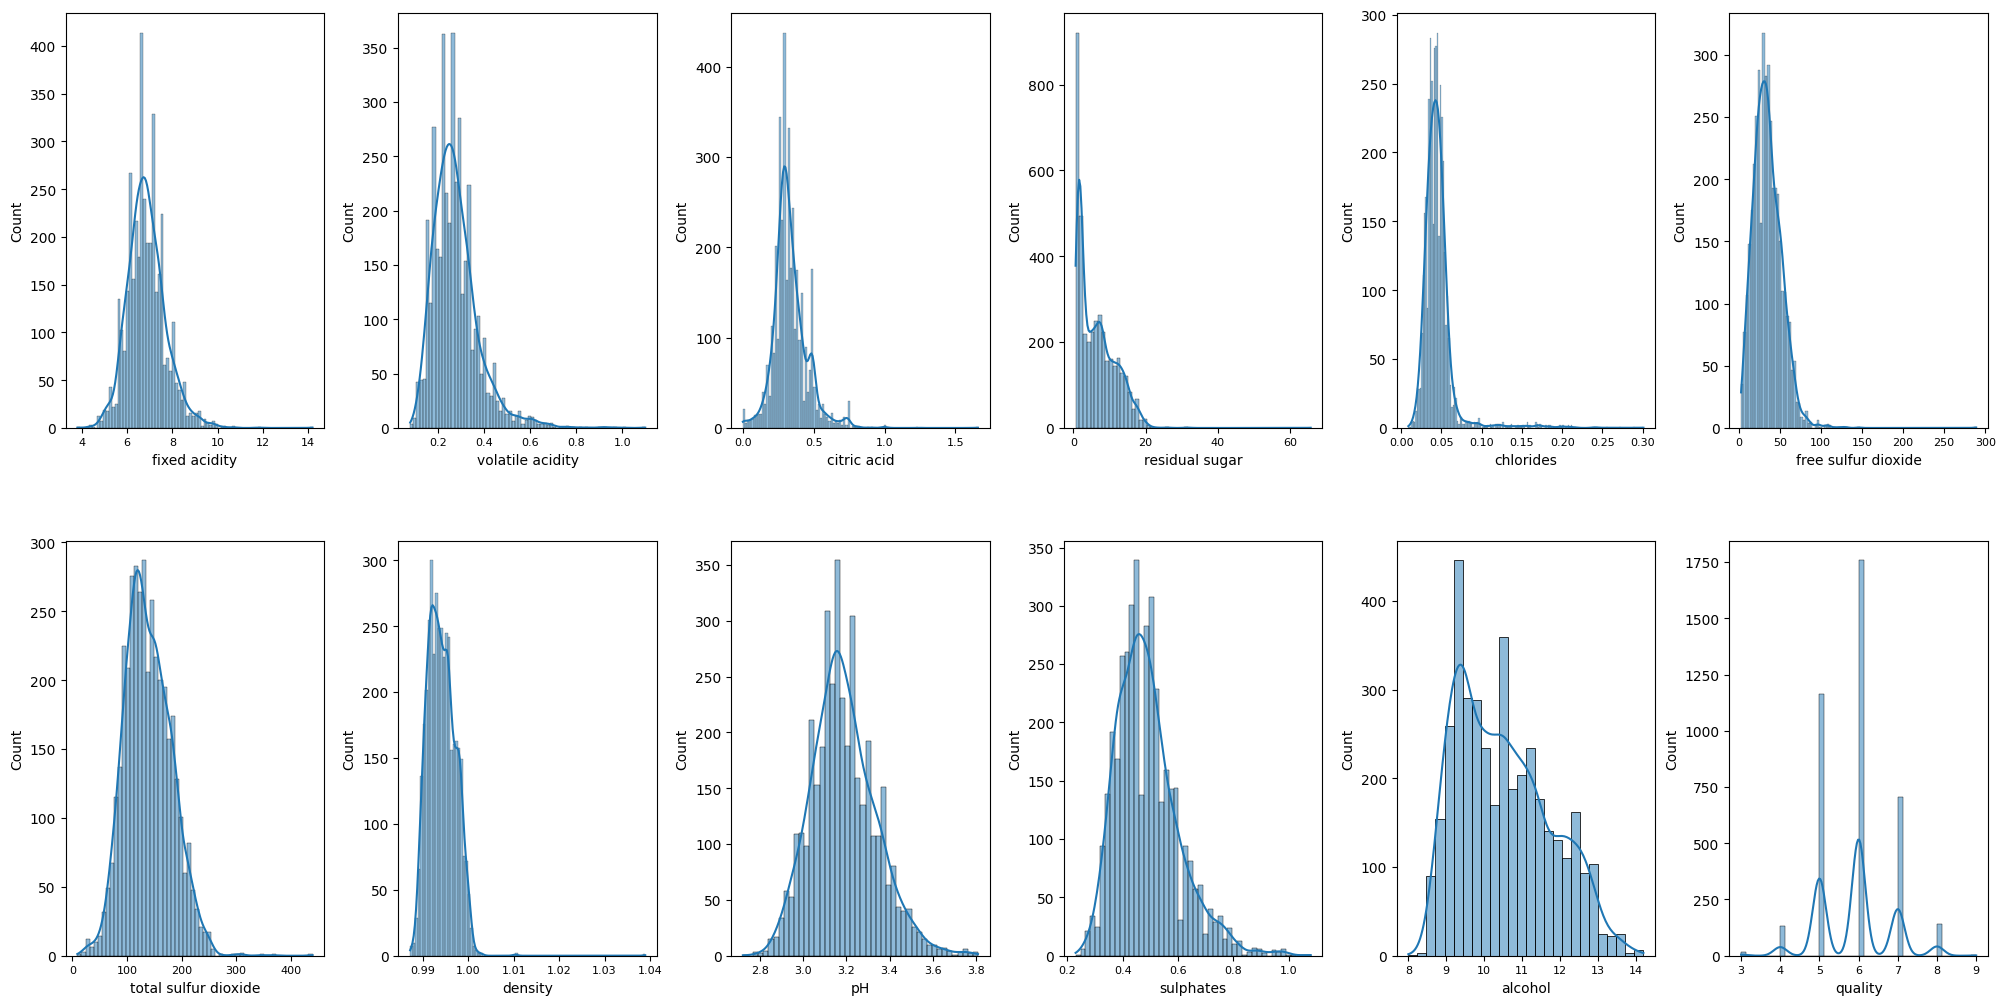

In [68]:
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(20,10))
index = 0
ax = ax.flatten()
for col, value in x_white_train.join(y_white_train).items():
    sns.histplot(value, ax=ax[index], kde=True)
    ax[index].xaxis.set_tick_params(labelsize=8)
    index += 1
print("WHITE WINE")
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)

RED WINE


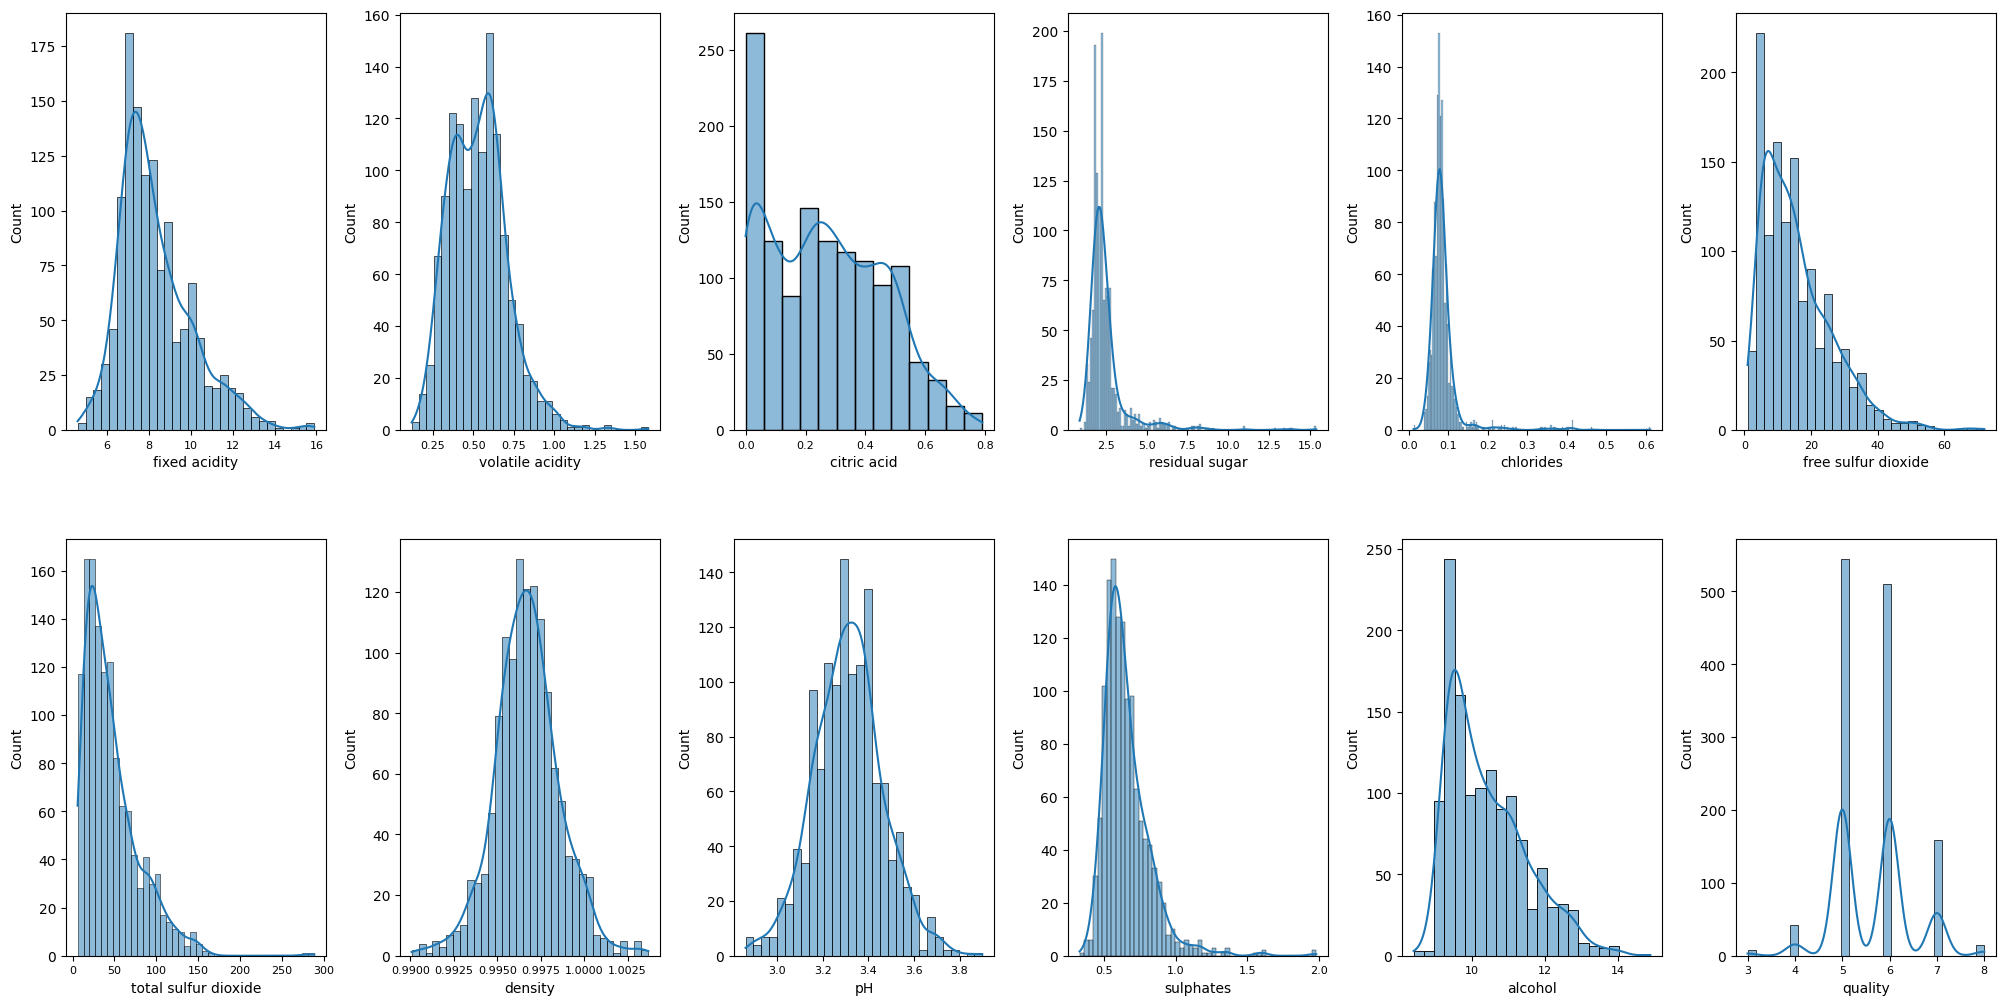

In [69]:
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(20,10))
index = 0
ax = ax.flatten()
for col, value in x_red_train.join(y_red_train).items():
    sns.histplot(value, ax=ax[index], kde=True)
    ax[index].xaxis.set_tick_params(labelsize=8)
    index += 1
print("RED WINE")
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)

<div class="rqT" title="Imbalanced dataset!">
Notice that both datasets are very imbalanced in terms of target distrubtion. Most of the wines are of quality 5 and 6. There are very few wines of poor quality (less than 4) or excellent quality (higher than 7). This will be a problem for modelling, as classification algorithms perform poorly when the training data doesn't contain enough samples of all classes. Classes that are underrepresented in the training data are called minority classes.. For instance, there are only 4 white wines with quality 9 in the training set, which means that 5-fold cross validation becomes impossible. Data augmentation techniques also struggle when the number of samples in minority classes is this low. Therefore, instead of predicting quality of each wine, I will change the goal to a more modest one: Predicting if the wine is poor, good or excellent quality. Another benefit of this is that the same procedure was done in the wine project, so the performance of my models should be easily compared with theirs.
</div>

### Relabeling of the dataset
<div class="intro" >
I will regroup and relabel wines into 3 categories based on their quality score (y):

1. Poor ($0 \le y \le 3$)
2. Good ($4 < y < 6$)
3. Excellent ($7 \le y \le 10$)

Now the task is to predict the category of each wine. Still, we can use both classification and regression algorthms for this task. The only difference is that the decision function now uses this definition to give the label based on the output of regression(see implementation in the code where we define regression models). Notice that now we have to perform encoding of these three classes for neural networks, while sckit-learn does that for us for linear models. Let's now relabel the training and test data, and see analyse relabeled training data. The summary of training data and conclusions are <a href='#datasetanalysis'>here</a> 

</div>

In [6]:
X_white_train = x_white_train; X_white_test = x_white_test
X_red_train = x_red_train; X_red_test = x_red_test
y_white_train["quality_label"] = ""
y_white_train.loc[y_white_train["quality"] <=3, "quality_label"] = 'Poor'
y_white_train.loc[((y_white_train["quality"] > 3) & (y_white_train["quality"] < 7)), "quality_label"] = 'Good'
y_white_train.loc[y_white_train["quality"] >= 7, "quality_label"] = 'Excellent'
Y_white_train = y_white_train[["quality"]].astype(np.float64) # Changing to float for regression
Y_label_white_train = y_white_train[["quality_label"]]
y_red_train["quality_label"] = ""
y_red_train.loc[y_red_train["quality"] <=3, "quality_label"] = 'Poor'
y_red_train.loc[((y_red_train["quality"] > 3) & (y_red_train["quality"] < 7)), "quality_label"] = 'Good'
y_red_train.loc[y_red_train["quality"] >= 7, "quality_label"] = 'Excellent'
Y_red_train = y_red_train[["quality"]].astype(np.float64) # Changing to float for regression
Y_label_red_train = y_red_train[["quality_label"]]
y_white_test["quality_label"] = ""
y_white_test.loc[y_white_test["quality"] <=3, "quality_label"] = 'Poor'
y_white_test.loc[((y_white_test["quality"] > 3) & (y_white_test["quality"] < 7)), "quality_label"] = 'Good'
y_white_test.loc[y_white_test["quality"] >= 7, "quality_label"] = 'Excellent'
Y_white_test = y_white_test[["quality"]].astype(np.float64) # Changing to float for regression
Y_label_white_test = y_white_test[["quality_label"]]
y_red_test["quality_label"] = ""
y_red_test.loc[y_red_test["quality"] <=3, "quality_label"] = 'Poor'
y_red_test.loc[((y_red_test["quality"] > 3) & (y_red_test["quality"] < 7)), "quality_label"] = 'Good'
y_red_test.loc[y_red_test["quality"] >= 7, "quality_label"] = 'Excellent'
Y_red_test = y_red_test[["quality"]].astype(np.float64) # Changing to float for regression
Y_label_red_test = y_red_test[["quality_label"]]

<a id="badaccuracy"></a>

In [71]:
# Distriubtion of regrouped classes
Y_dist_white = Y_label_white_train.groupby("quality_label")["quality_label"].count()
Y_dist_red = Y_label_red_train.groupby("quality_label")["quality_label"].count()
print(Y_dist_white/Y_dist_white.sum())
print(Y_dist_red/Y_dist_red.sum())

quality_label
Excellent    0.216437
Good         0.779479
Poor         0.004084
Name: quality_label, dtype: float64
quality_label
Excellent    0.136044
Good         0.857701
Poor         0.006255
Name: quality_label, dtype: float64


#### Features and target distributions

WHITE WINE


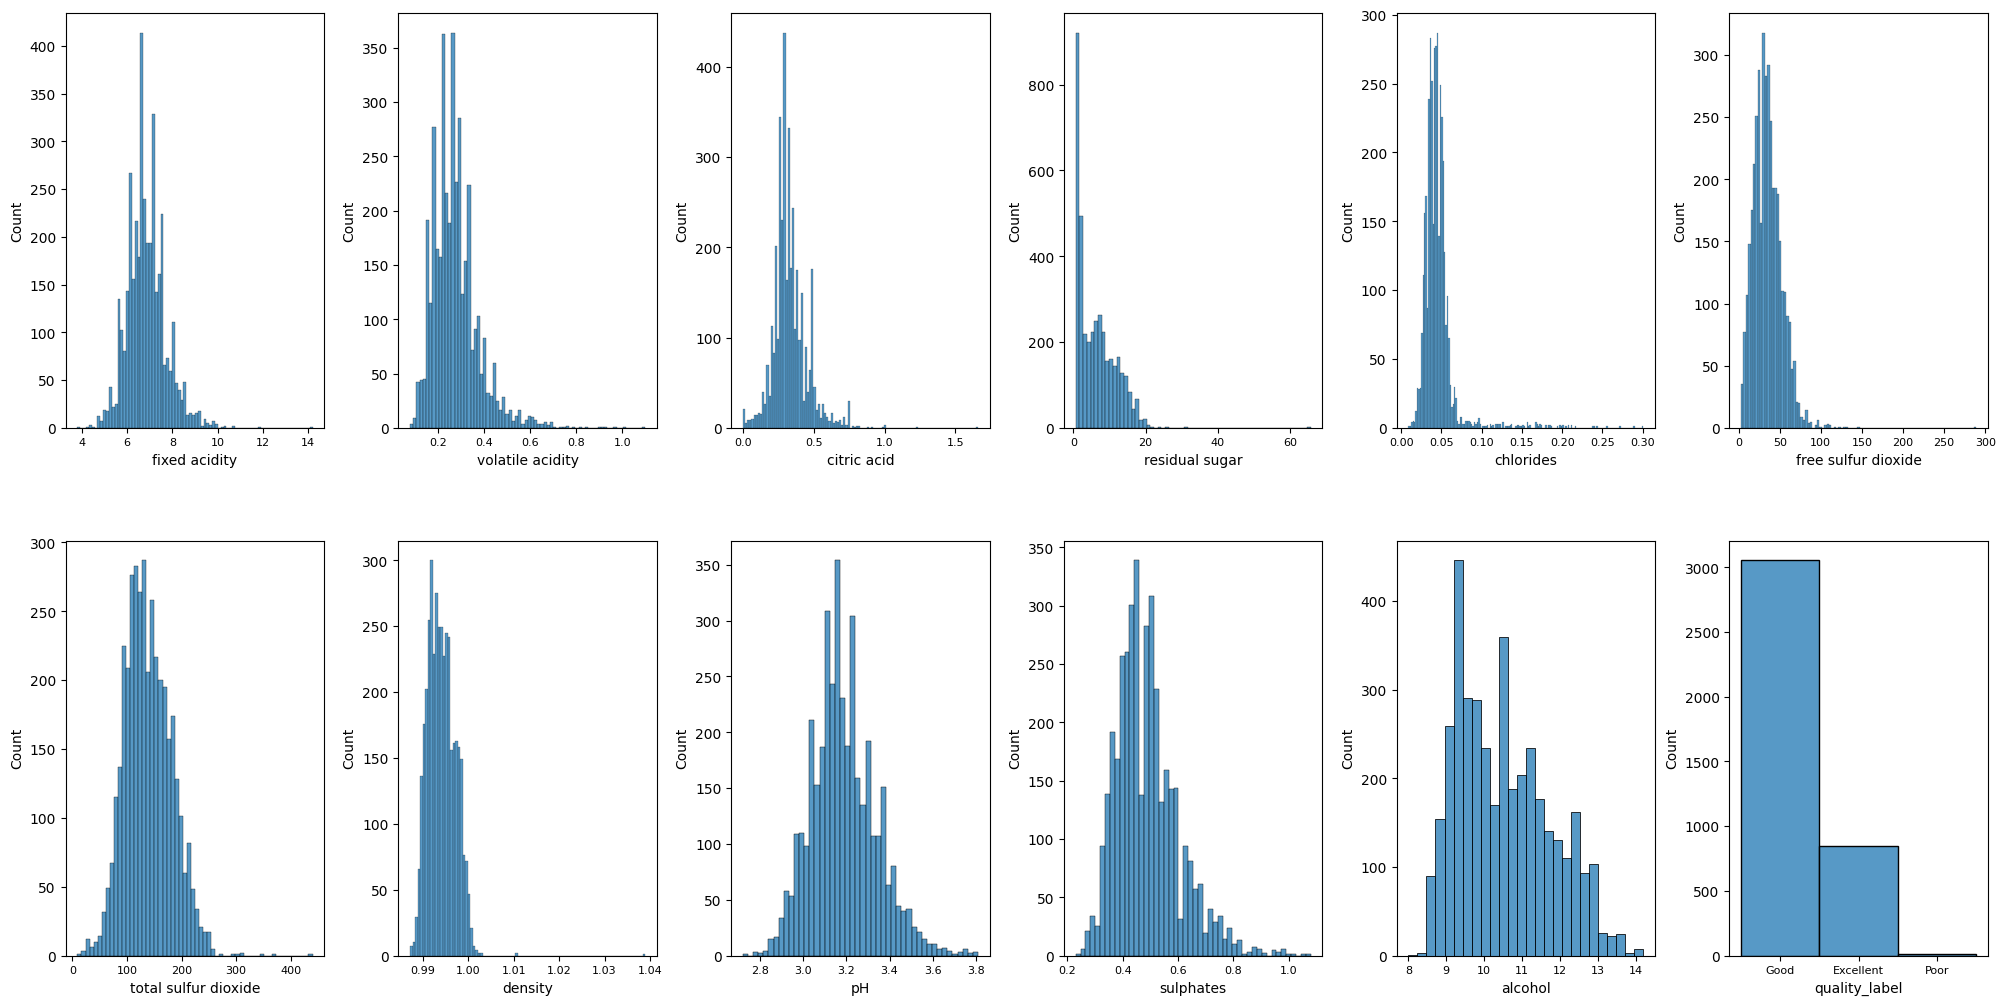

In [72]:
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(20,10))
index = 0
ax = ax.flatten()
for col, value in X_white_train.join(Y_label_white_train).items():
    sns.histplot(value, ax=ax[index])
    ax[index].xaxis.set_tick_params(labelsize=8)
    index += 1
print("WHITE WINE")
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)

RED WINE


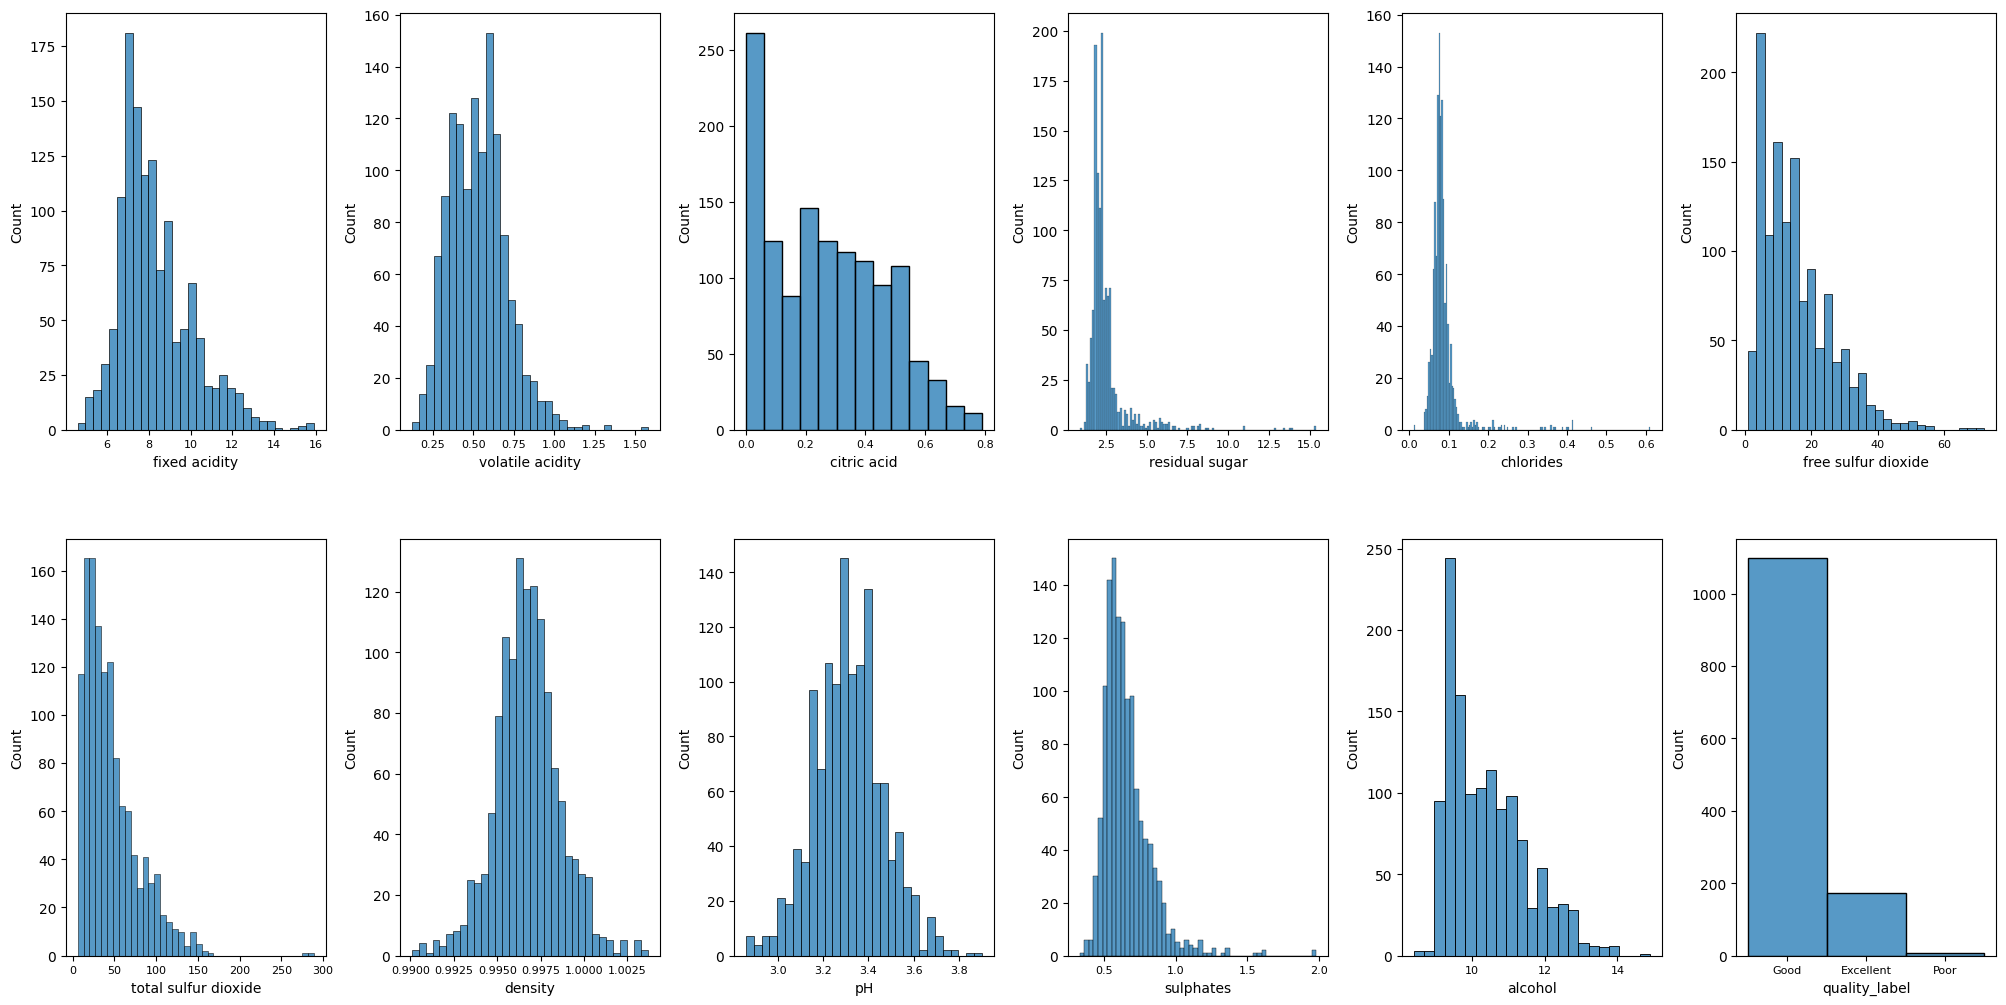

In [73]:
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(20,10))
index = 0
ax = ax.flatten()
for col, value in X_red_train.join(Y_label_red_train).items():
    sns.histplot(value, ax=ax[index])
    ax[index].xaxis.set_tick_params(labelsize=8)
    index += 1
print("RED WINE")
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)

Notice that despite this relabeling, class of poor quality wines is still heavily underrepresented. Also notice the distribution of most of the features is highly irregular. There are some outliers in some of those distributions.

#### Pairplot of features

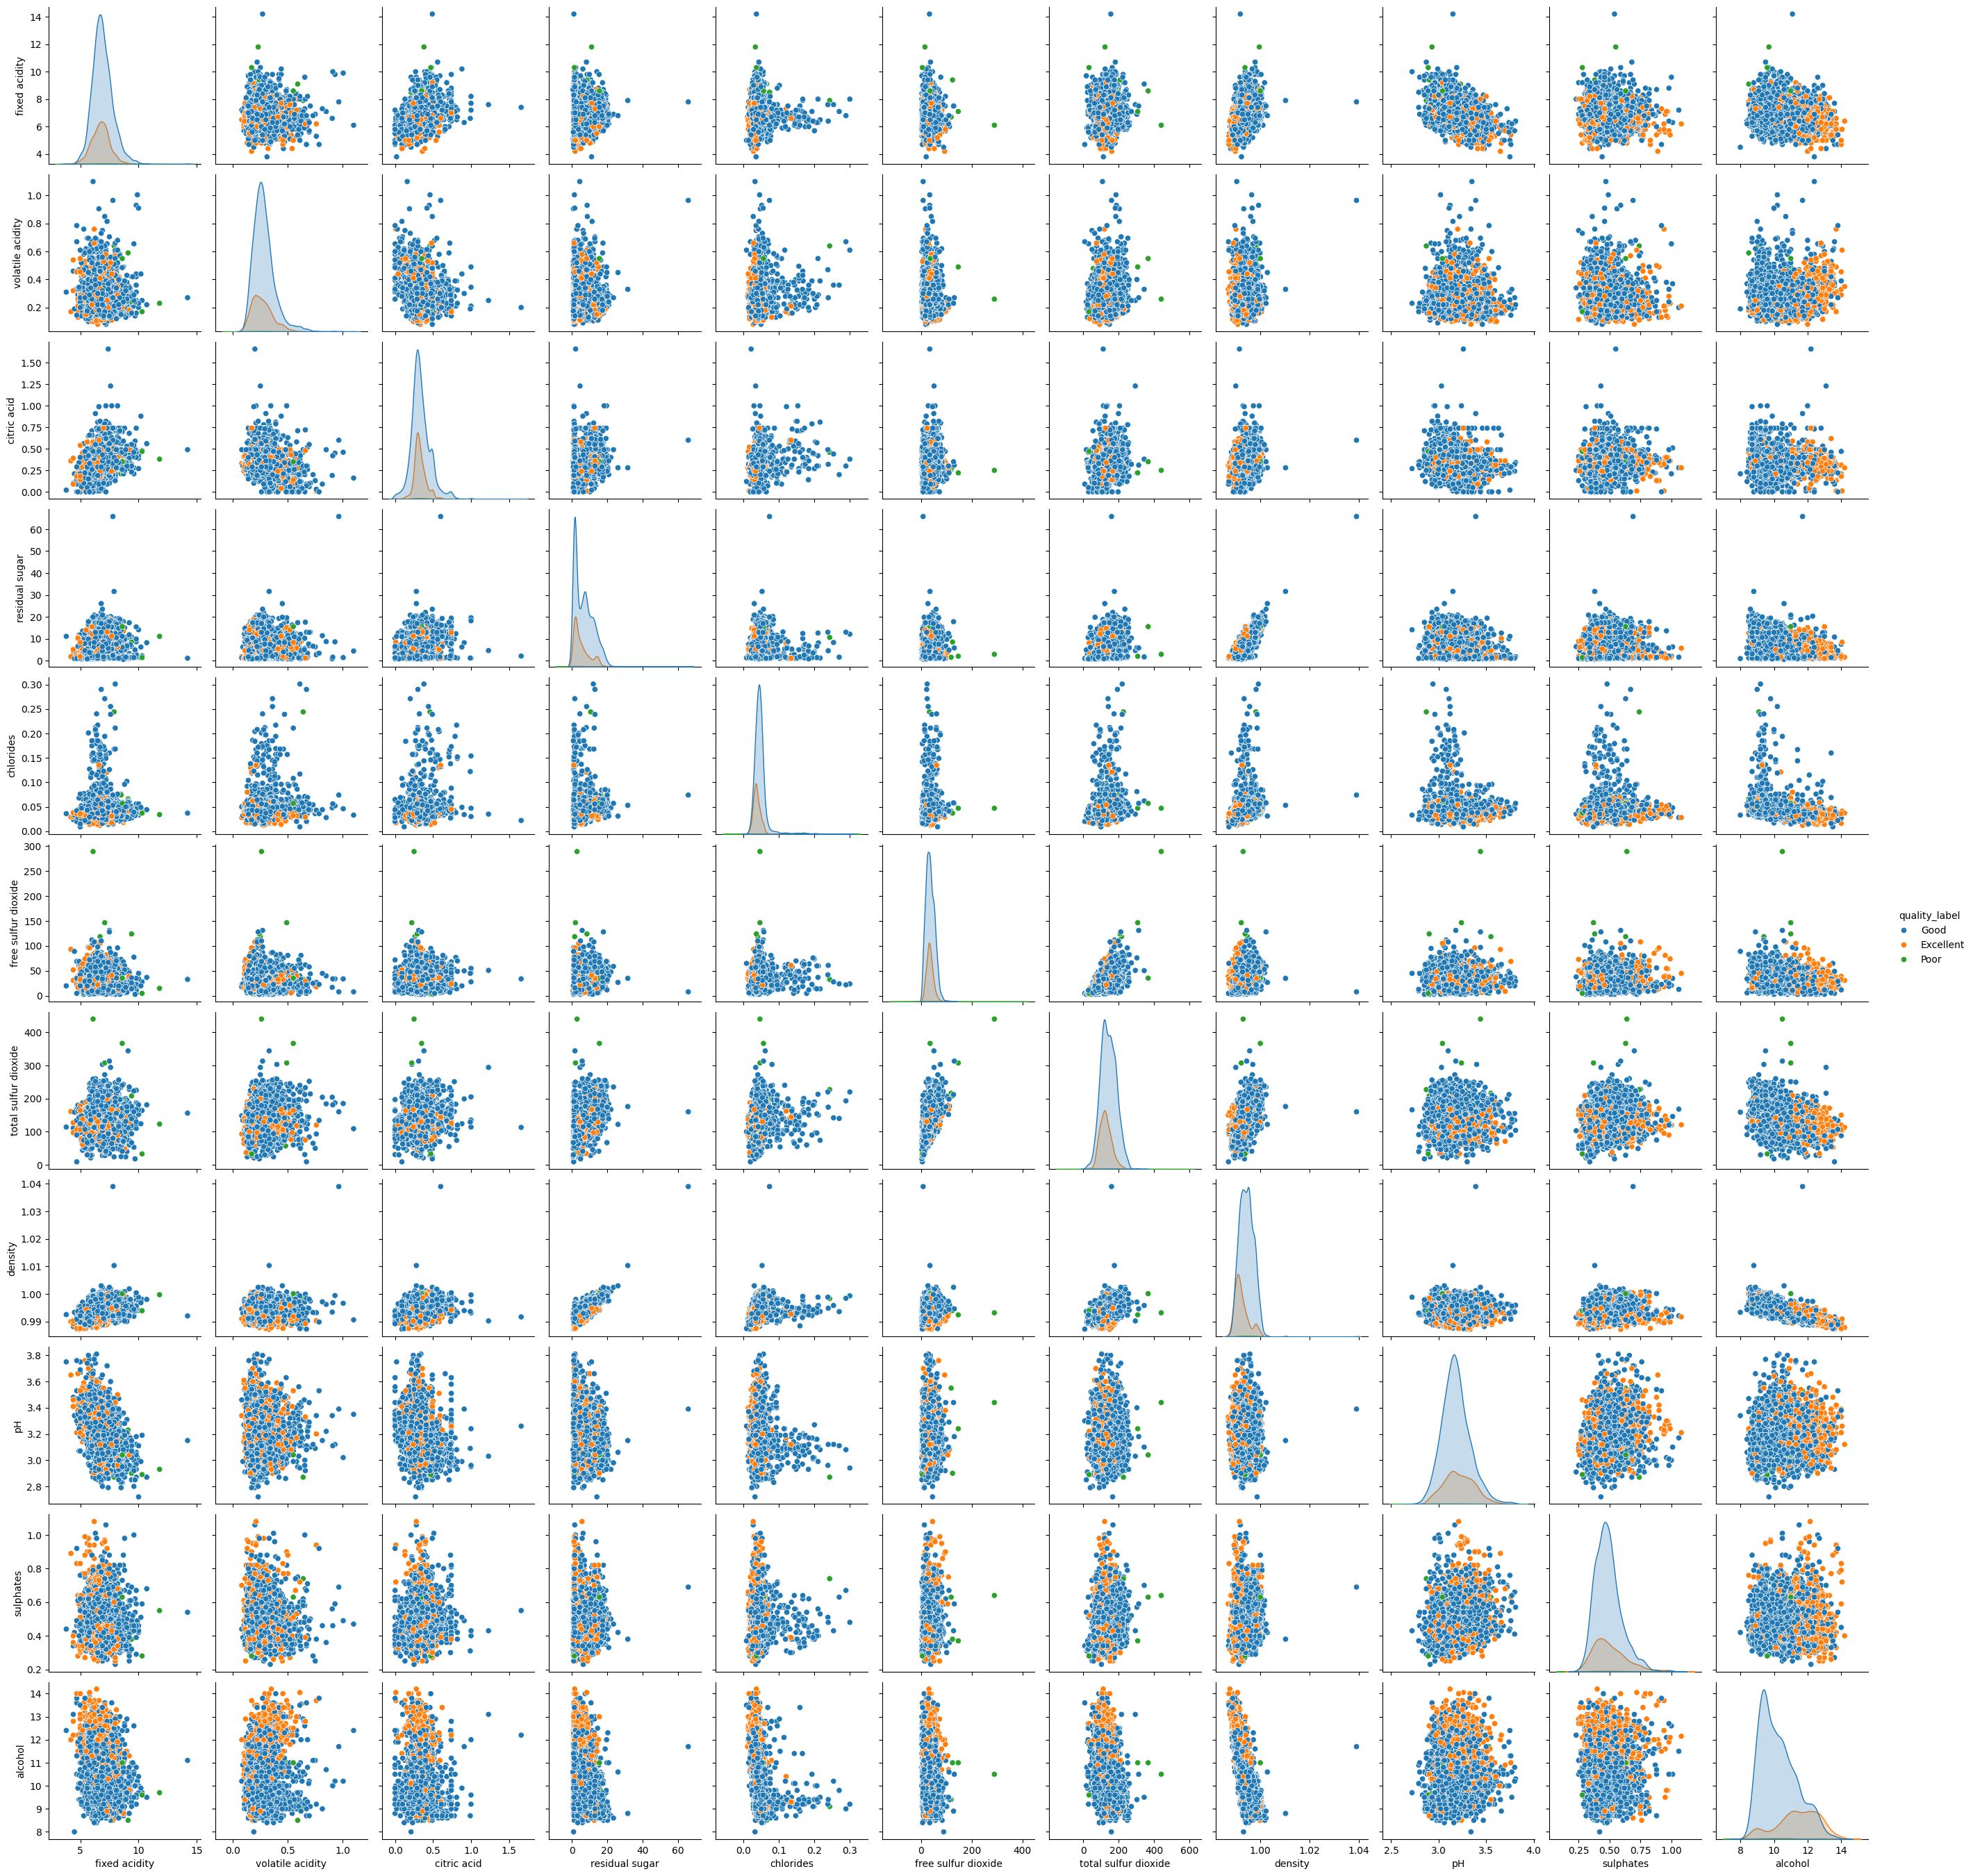

In [74]:
sns.pairplot(data=X_white_train.join(Y_label_white_train), hue="quality_label");

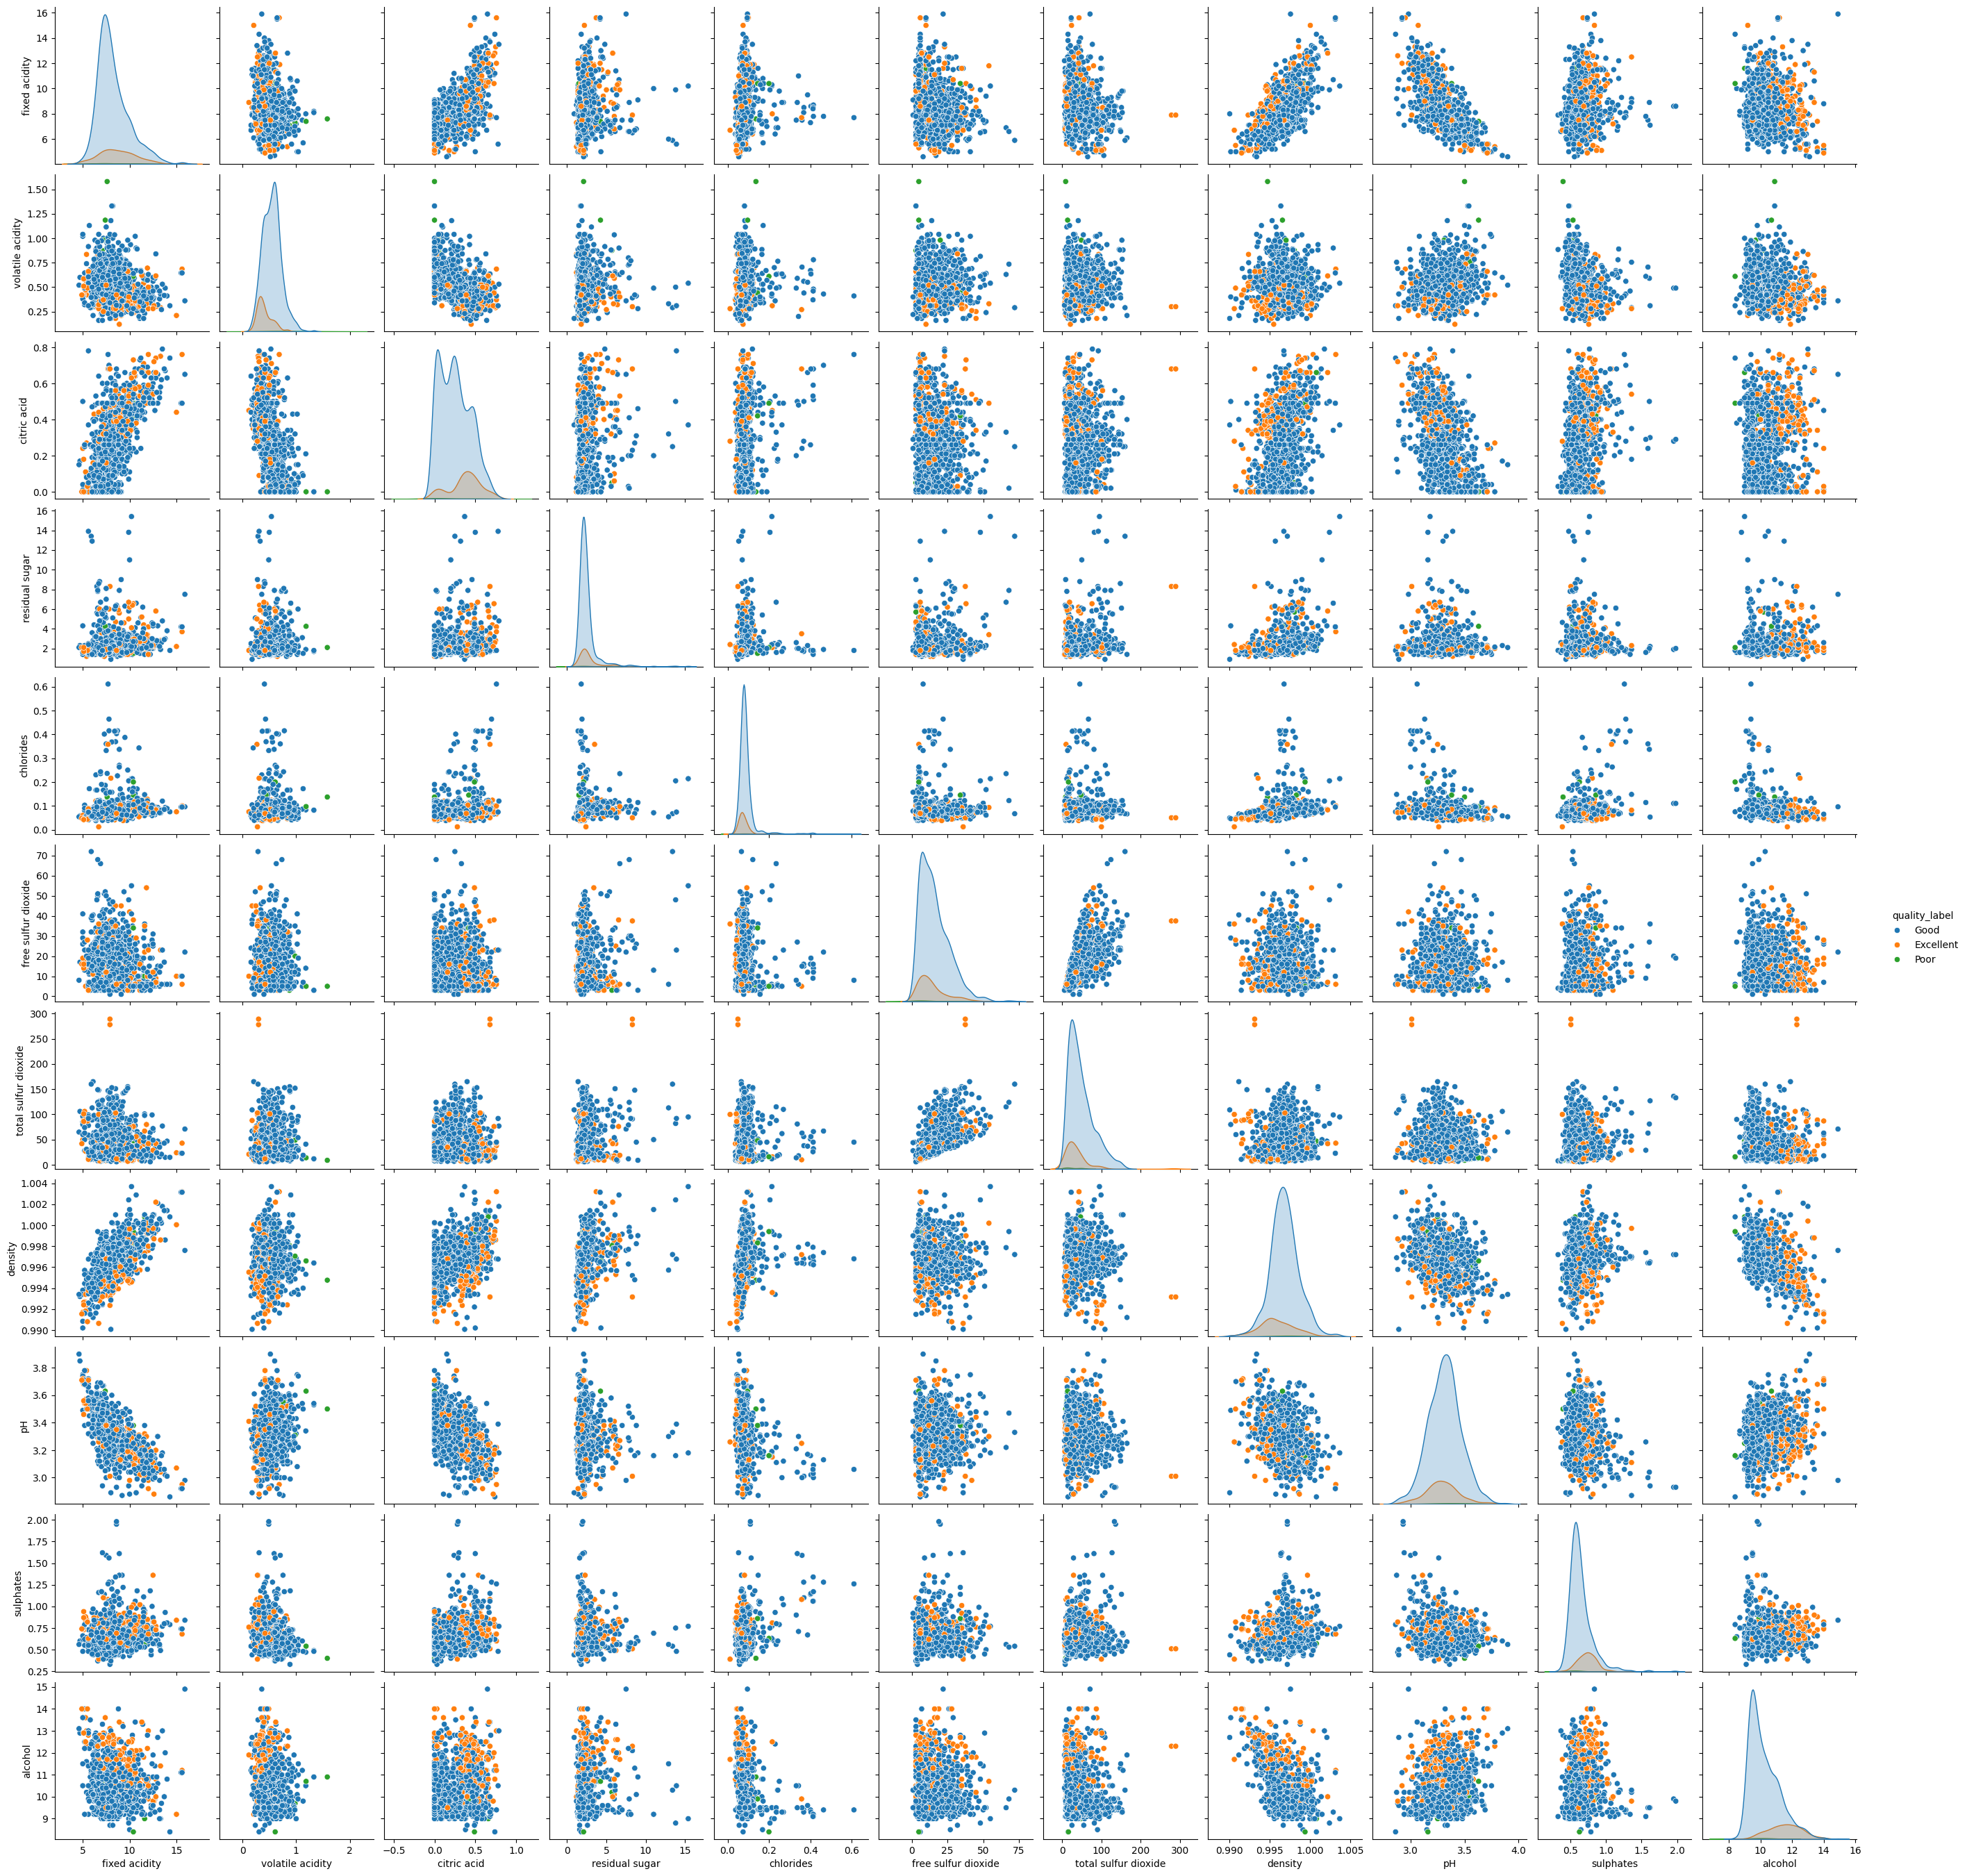

In [75]:
sns.pairplot(data=X_red_train.join(Y_label_red_train), hue="quality_label");

Notice that most of the outliers are in minority class, so removing outliers is not a good idea.

#### Pointplots

WHITE WINE


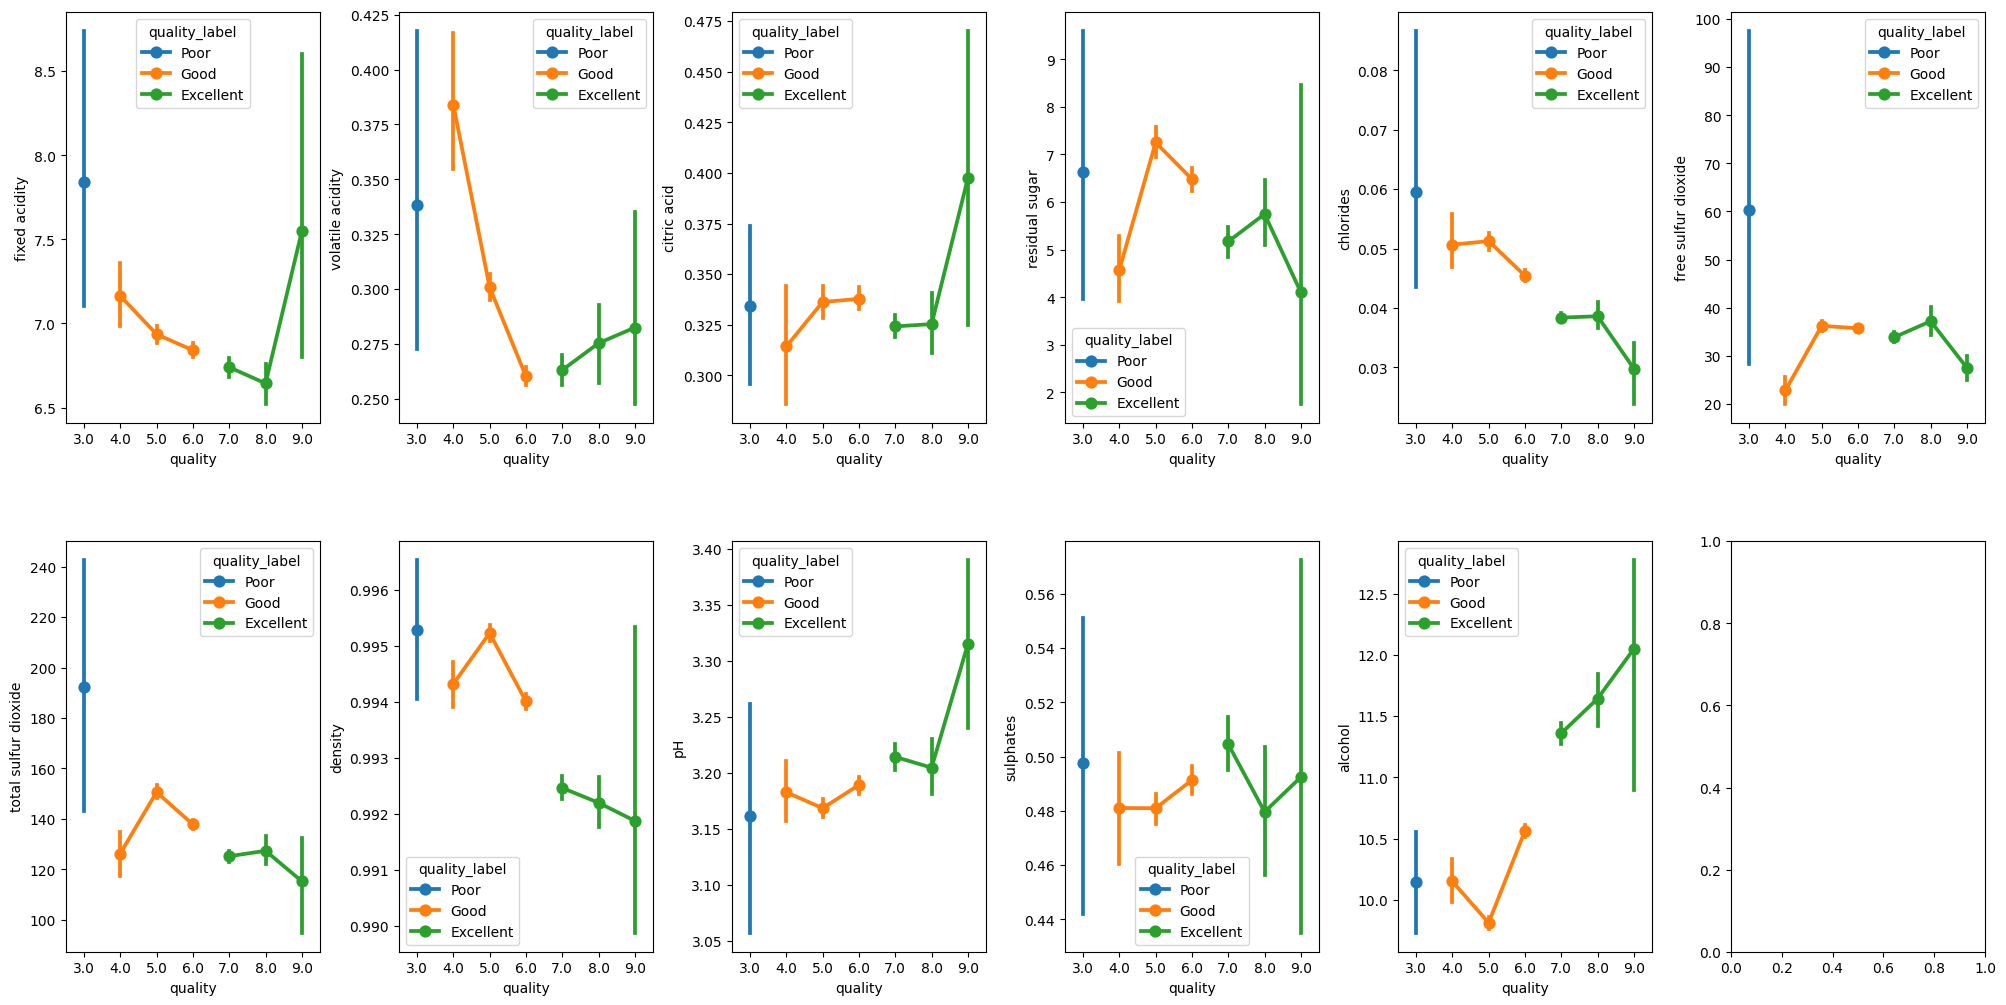

In [76]:
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(20,10))
index = 0
ax = ax.flatten()
for col, value in X_white_train.items():
    sns.pointplot(x=Y_white_train["quality"], y=X_white_train[col],hue=Y_label_white_train["quality_label"],
                   ax=ax[index])
    index += 1
print("WHITE WINE")
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)

RED WINE


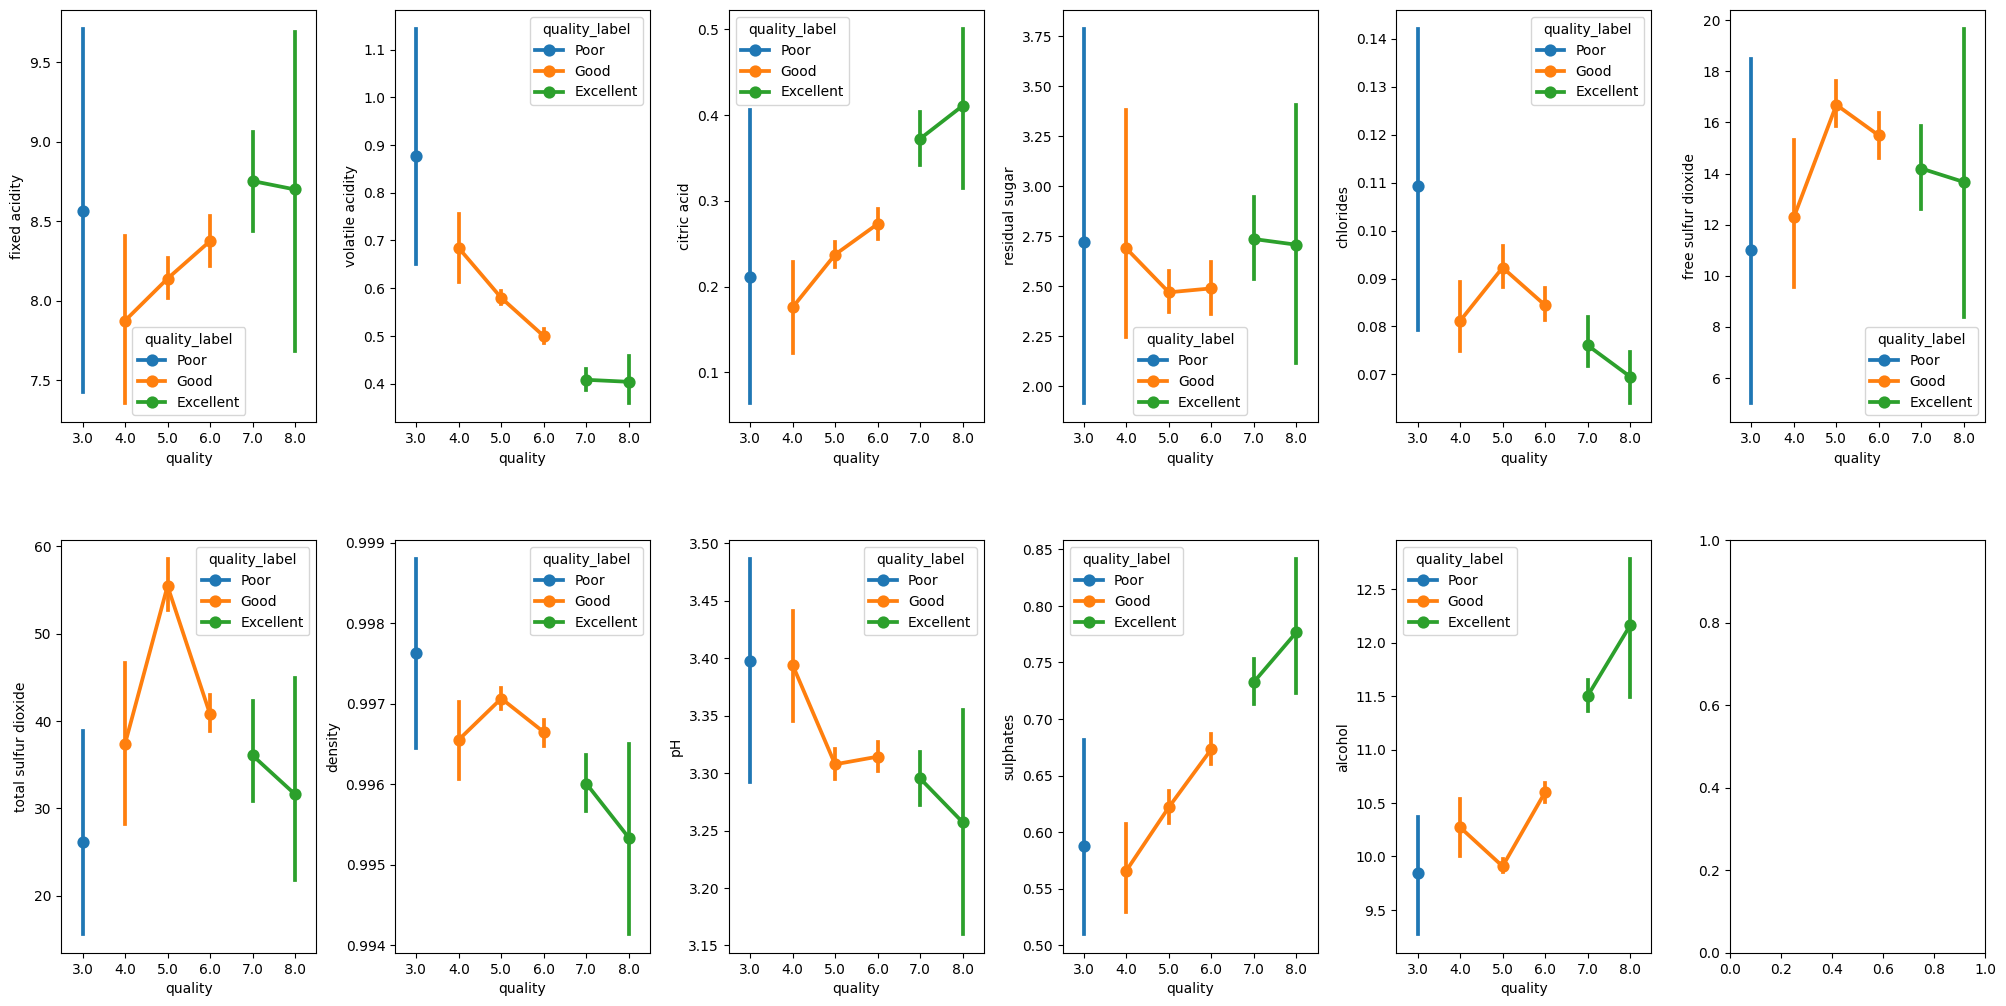

In [77]:
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(20,10))
index = 0
ax = ax.flatten()
for col, value in X_red_train.items():
    sns.pointplot(x=Y_red_train["quality"], y=X_red_train[col],hue=Y_label_red_train["quality_label"],
                   ax=ax[index])
    index += 1
print("RED WINE")
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)

#### Correlation matrix

WHITE WINE


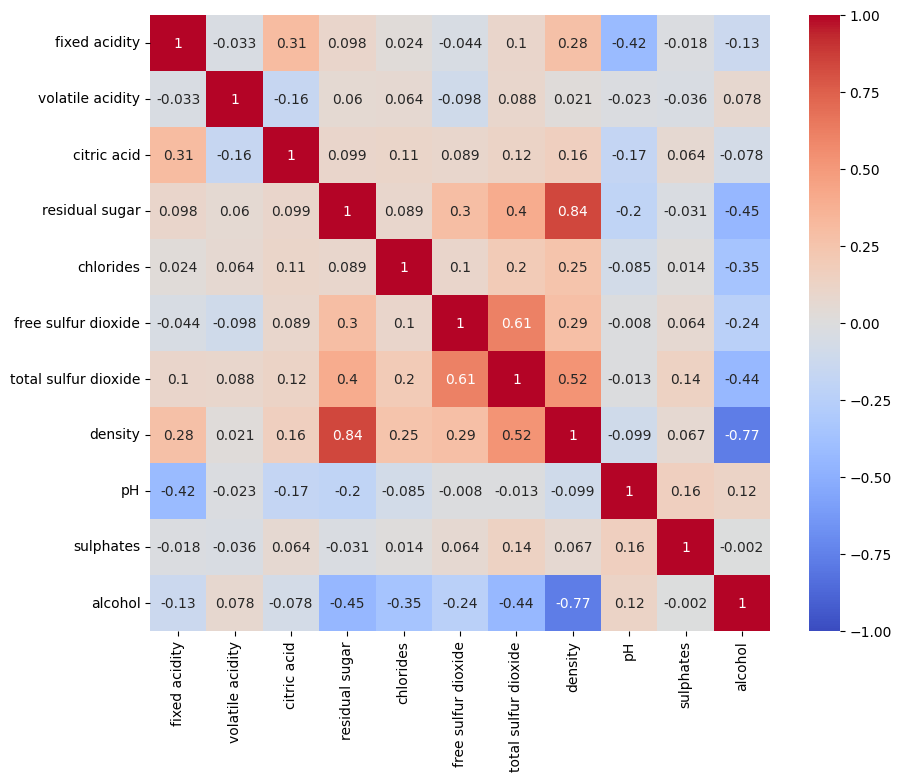

In [78]:
plt.figure(figsize = (10,8))
sns.heatmap(np.round(X_white_train.corr(numeric_only=True),decimals=3), vmin = -1, vmax = +1, annot = True, cmap='coolwarm');
print("WHITE WINE")

RED WINE


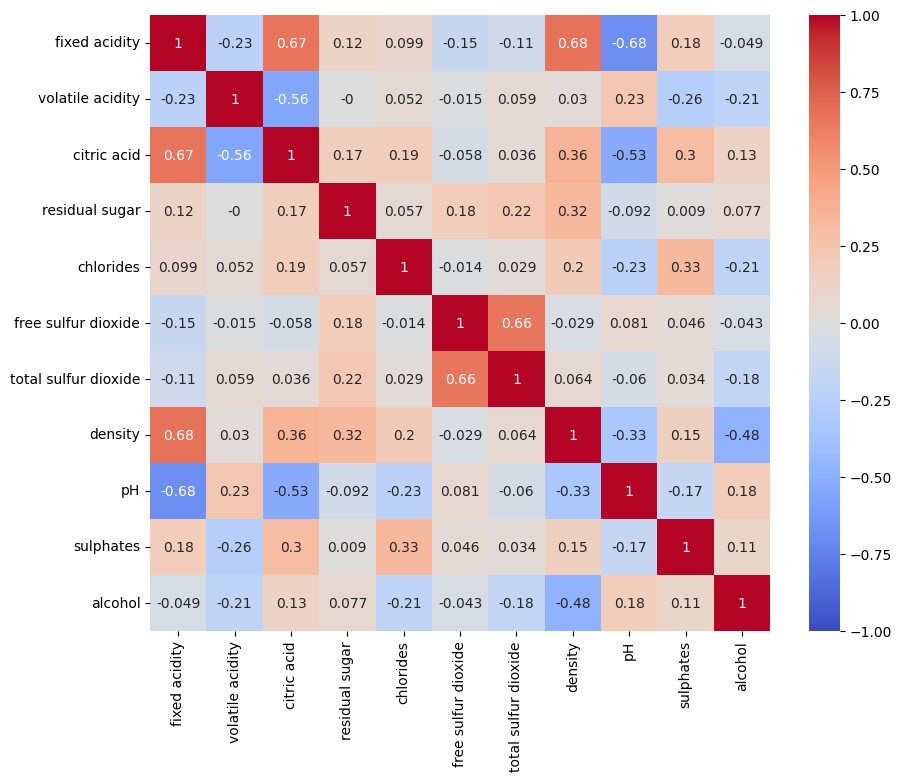

In [79]:
plt.figure(figsize = (10,8))
sns.heatmap(np.round(X_red_train.corr(numeric_only=True),decimals=3), vmin = -1, vmax = +1, annot = True, cmap='coolwarm');
print("RED WINE")

## Dataset Analysis <a id='datasetanalysis'></a>

### Observations

<div class="intro">

* The range of values features take is different for different features. Therefore, standardization of feature values must be performed. However, distributions of features are scewed due to presence of outliers.

* We can spot certain outlayers in pairplot graph. However, those can't be just discardered, as the analysis showed that most of them are from minority classes.

* Wines of excellent quality and especially wines of bad quality are not sufficiently represented in the dataset. From pointplots we can see that wines with extremes in terms of quality have distribution of features. This means usual statistical analysis is not useful and task is challenging even for ML models.

* Features are descriptive, as it can be seen from the pointplots. However, we might not have all the features needed to succesfully predict the quality. We can't know that in advance.

* Features are generally not correlated, with one important exception for white wines: density is highly correlated with residual sugar and alcohol features.

</div>

### Conclusions

<div class="intro">

* The features will be scaled using <a href="https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler"> robust scaler</a>, as it's more robust in cases with scewed distributions of featues.

* Outliers will be kept.

* Data augemntation will be performed. The <a href="https://imbalanced-learn.org/stable/over_sampling.html#smote-adasyn"> SMOTE </a> and <a href="https://imbalanced-learn.org/stable/over_sampling.html#random-over-sampler">RandomOverSampler</a> oversampling techniques will be tested.

* All features will be used for predictions, as we have only 11 features and they are all descirptive.

* Separate models will be build for red and white wines. There is no right or wrong answer here, and in principle introducing wine type descriptor and combining both datasets into one is also viable approach. However, I will threat them completely separately.

</div>

## Bulding and training models

### Remarks about methods for building and training models

<div class="intro">

* Two linear models are build just for the comparison with ANN models. Even these small ANN took around three orders of magnitude longer to train. The goal is to see if this additional effort brings enough improvement on the performance.
* Validation of the models will be done using 5-fold cross validation technique. Hyperparamter optimization is done using <a href="https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html"> BayesSearchCV </a>. In this search a small bayesian inference model is trained to predict the best hyperparameters to test in the next cycle based on the scoring of previously tested models.
* Only simple shallow ANN architectures with 2-5 fully-connected hidden layers and constant layer width will be tested. This vanilla ANNs are inferior compared to the other ANN architecures. However, they are simple to build and train and the idea is to compare simple ANN with simple linear models.
* Early stopping will be used for training ANNs with internal 20% validation set.
* Balanced accuracy will be used a scoring function in hyperparameter search, and in general, this will be the main evaluation metric. See more about evaluation metrics <a href=#Model-Evaluation> here </a>

</div>

In [6]:
from sklearn.preprocessing import RobustScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.metrics import make_scorer
from sklearn.metrics import balanced_accuracy_score
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.linear_model import LogisticRegression, Ridge
import torch
from torch import nn
torch.manual_seed(7)
torch.set_default_dtype(torch.float64)
from skorch import NeuralNetClassifier, NeuralNetRegressor
from skorch.callbacks import EarlyStopping, LRScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
dev = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

Here I put all the small modifications in order to use regression models for ordinal classification.

In [10]:
# helper function needed to decode encoded quality label
def classify(x):
            if x <= 3:
                return "Poor"
            elif x > 3 and x < 7:
                 return "Good"
            elif x >= 7:
                return "Excellent"
classify = np.vectorize(classify)
# making custom scoring function to implement balanced accuracy for regression
def balanced_accuracy_regression(y_true,y_predicted):
      y_true = classify(y_true)
      y_predicted = classify(y_predicted)
      return balanced_accuracy_score(y_true,y_predicted)
balanced_accuracy_regression_score = make_scorer(balanced_accuracy_regression,greater_is_better=True)
# Modifying regression so it can compute integer wine quality score
class OrdinalRegressionClassifier(Ridge):
    def decision_function(self,X):
        Y = super().predict(X)
        return classify(Y)
class NNClassifier(NeuralNetClassifier):
    def decision_function(self,X):
        def decode(x):
            if x == 0:
                return "Poor"
            elif x == 1:
                 return "Good"
            elif x == 2:
                return "Excellent"
        Y = super().predict(X)
        return np.vectorize(decode)(Y)
# Hotfix in order to use RandomOverSampler for regression
class RandomOverSampler(RandomOverSampler):
    def fit_resample(self, X, y):
        X, y =  super().fit_resample(X, y)
        return X, y.reshape(-1,1)
class NNRegressor(NeuralNetRegressor):
    def decision_function(self,X):
        Y = super().predict(X)
        return classify(Y)

<div class="rqT" title="Don't train models in this notebook. Load them instead">
The Neural Network modules are defined here so that by running these cells models can be loaded and the training skipped. Don't try to run the training, it can take several hours! Run the following three cells instead.
</div>

In [12]:
# Softmax classifier neural network
class ModuleClassifier(nn.Module):
    def __init__(self, n_layers=2,layer_width=50,n_class=11,n_features=11):
        super(ModuleClassifier,self).__init__()
        self.layers = []
        self.acts = []
        self.layers.append(nn.Linear(n_features, layer_width))
        self.acts.append(nn.ReLU())
        for _ in range(n_layers):
            self.layers.append(nn.Linear(layer_width, layer_width))
            self.acts.append(nn.ReLU())
        self.output = nn.Linear(layer_width, n_class)
    def forward(self, x):
        for layer, act in zip(self.layers, self.acts):
            x = act(layer(x))
        x = self.output(x)
        return x

In [13]:
# Regression neural network
class ModuleRegressor(nn.Module):
    def __init__(self, n_layers=2,layer_width=50,n_features=11):
        super(ModuleRegressor,self).__init__()
        self.layers = []
        self.acts = []
        self.layers.append(nn.Linear(n_features, layer_width))
        self.acts.append(nn.ReLU())
        for _ in range(n_layers):
            self.layers.append(nn.Linear(layer_width, layer_width))
            self.acts.append(nn.ReLU())
        self.output = nn.Linear(layer_width,1)
    def forward(self, x):
        for layer, act in zip(self.layers, self.acts):
            x = act(layer(x))
        x = self.output(x)
        return x

In [61]:
# Run this cell to load models instead of training models
with open('models/model1_white.pkl', 'rb') as f:
    model1_white = pickle.load(f)
with open('models/model1_red.pkl', 'rb') as f:
    model1_red = pickle.load(f)
with open('models/model2_white.pkl', 'rb') as f:
    model2_white = pickle.load(f)
with open('models/model2_red.pkl', 'rb') as f:
    model2_red = pickle.load(f)
with open('models/model3_white.pkl', 'rb') as f:
    model3_white = pickle.load(f)
with open('models/model3_red.pkl', 'rb') as f:
    model3_red = pickle.load(f)
with open('models/model4_white.pkl', 'rb') as f:
    model4_white = pickle.load(f)
with open('models/model4_red.pkl', 'rb') as f:
    model4_red = pickle.load(f);

### Linear Logistic Regression for ordinal classification

<div class="intro">
For multilabel classification (like we have here) three main implementation of logistic regression are present: one-versus-rest, one-versus-one, and true multinomial. I will use true multinomial, linear logistic regression <a href="https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression">as implemented in scikit-learn</a>. In this implementation, a regularization hyperparameter C controls regularization.
</div>
<div class="rqT" title='Note on "linear" Logistic Regression'>
Logistic regression is classification algorithm despite it's name. Logistic regression is not linear in direct sense, but the log-odds are a linear combinations of features. Here it comes to other name for this class of models: log-linear classifier.
</div>

In [82]:
model1 = Pipeline([("scaler",RobustScaler()),
                 ("data_augmentation",SMOTE(random_state=7,k_neighbors=3)),
                 ("regressor",LogisticRegression(multi_class='multinomial',
                                                 class_weight='balanced',
                                                 C=1e-1,
                                                 max_iter=1000,
                                                 solver='saga',
                                                 random_state=7)),
                 ])

In [83]:
param_grid1 = [
  {'scaler' : Categorical([RobustScaler()]),
   'data_augmentation' : Categorical([SMOTE(random_state=7,k_neighbors=4)]),
   'regressor__C': Real(1e-4, 5e-1, prior='log-uniform'),
   },
   {'scaler' : Categorical([RobustScaler()]),
   'data_augmentation' : Categorical([RandomOverSampler(random_state=7)]),
   'data_augmentation__shrinkage' : Real(0.1,1.0),
   'regressor__C': Real(1e-4, 5e-1, prior='log-uniform'),
   },
   {'scaler' : Categorical([RobustScaler()]),
   'data_augmentation' : Categorical(["passthrough"]),
   'regressor__C': Real(1e-4, 5-1, prior='log-uniform'),
   },
 ]

In [84]:
hyperparam_opt1_red = BayesSearchCV(model1, search_spaces=param_grid1, random_state=7,cv=5,
                                    scoring='balanced_accuracy')
hyperparam_opt1_white = BayesSearchCV(model1, search_spaces=param_grid1, random_state=7,cv=5,
                                      scoring='balanced_accuracy')
hyperparam_opt1_red.fit(X_red_train, Y_label_red_train["quality_label"])
hyperparam_opt1_white.fit(X_white_train, Y_label_white_train["quality_label"])

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                        ('data_augmentation',
                                         SMOTE(k_neighbors=3, random_state=7)),
                                        ('regressor',
                                         LogisticRegression(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=1000,
                                                            multi_class='multinomial',
                                                            random_state=7,
                                                            solver='saga'))]),
              random_state=7, scoring='balanced_accuracy',
              search_spaces=[{'data_augmentation': Categor...
                              'regressor__C': Real(low=0.0001, high=0.5, prior='log-uniform', transform='normalize'),
                              'scaler': Categorical(categories=(RobustScaler(),), prior=None)},
                             {'data_augmentation': Categorical(categories=('passthrough',), prior=None),
                              'regressor__C': Real(low=0.0001, high=4, prior='log-uniform', transform='normalize'),
                              'scaler': Categorical(categories=(RobustScaler(),), prior=None)}])

In [85]:
# Check best hyperparameters
print(hyperparam_opt1_white.best_params_)
print(hyperparam_opt1_red.best_params_)

OrderedDict([('data_augmentation', RandomOverSampler(random_state=7)), ('data_augmentation__shrinkage', 1.0), ('regressor__C', 0.0007057796875946206), ('scaler', RobustScaler())])
OrderedDict([('data_augmentation', RandomOverSampler(random_state=7)), ('data_augmentation__shrinkage', 0.5029033348086182), ('regressor__C', 0.18669720253669778), ('scaler', RobustScaler())])


In [86]:
# Saving models
model1_red = hyperparam_opt1_red.best_estimator_
model1_white = hyperparam_opt1_white.best_estimator_
with open('model1_white.pkl', 'wb') as f:
    pickle.dump(model1_white, f)
with open('model1_red.pkl', 'wb') as f:
    pickle.dump(model1_red, f)

To see models' evaluation, go <a href=#Model-Evaluation> here</a>.

### Linear Ridge Regression for ordinal classification
For linear regression model, I opted for <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html">Ridge model</a>. It's relatively simple model with only one regularization parameters that punishes the size of coefficient in linear regression. Notice that for regression we will use information about scores, and later predict the label. This also means we can't use SMOTE to augment data, because class of quality 9 has too little elements in case of white wine. This is not a big problem, as regressions tasks are much less sensitive to imbalances.

In [88]:
model2 = Pipeline([("scaler",RobustScaler()),
                       ('data_augmentation',RandomOverSampler(random_state=7)),
                       ("regressor",OrdinalRegressionClassifier(random_state=7)),
                 ])

In [89]:
param_grid2 = [
   {'scaler' : Categorical([RobustScaler()]),
   'data_augmentation' : Categorical([RandomOverSampler(random_state=7)]),
   'data_augmentation__shrinkage' : Real(0.1,1.0),
   'regressor__alpha': Real(1e+0, 1e+3, prior='log-uniform'),
   },
   {'scaler' : Categorical([RobustScaler()]),
   'data_augmentation' : Categorical(["passthrough"]),
   'regressor__alpha': Real(1e+0, 1e+3, prior='log-uniform'),
   },
 ]

In [90]:
hyperparam_opt2_red = BayesSearchCV(
    model2, search_spaces=param_grid2, scoring=balanced_accuracy_regression_score, random_state=7,cv=5)
hyperparam_opt2_white = BayesSearchCV(
    model2, search_spaces=param_grid2, scoring=balanced_accuracy_regression_score, random_state=7,cv=5)
hyperparam_opt2_red.fit(X_red_train, Y_red_train["quality"])
hyperparam_opt2_white.fit(X_white_train, Y_white_train["quality"])

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                        ('data_augmentation',
                                         RandomOverSampler(random_state=7)),
                                        ('regressor',
                                         OrdinalRegressionClassifier(random_state=7))]),
              random_state=7, scoring=make_scorer(balanced_accuracy_regression),
              search_spaces=[{'data_augmentation': Categorical(categories=(RandomOverSampler(random_state=7),), pr...
                              'regressor__alpha': Real(low=1.0, high=1000.0, prior='log-uniform', transform='normalize'),
                              'scaler': Categorical(categories=(RobustScaler(),), prior=None)},
                             {'data_augmentation': Categorical(categories=('passthrough',), prior=None),
                              'regressor__alpha': Real(low=1.0, high=1000.0, prior='log-uniform', transform='normalize'),
                              'scaler': Categorical(categories=(RobustScaler(),), prior=None)}])

In [91]:
# Check best hyperparameters
print(hyperparam_opt2_white.best_params_)
print(hyperparam_opt2_red.best_params_)

OrderedDict([('data_augmentation', RandomOverSampler(random_state=7)), ('data_augmentation__shrinkage', 0.28352208191960193), ('regressor__alpha', 1.9633297539618444), ('scaler', RobustScaler())])
OrderedDict([('data_augmentation', RandomOverSampler(random_state=7)), ('data_augmentation__shrinkage', 0.1), ('regressor__alpha', 61.264798836512206), ('scaler', RobustScaler())])


In [92]:
# Saving models
model2_white = hyperparam_opt2_white.best_estimator_
model2_red = hyperparam_opt2_red.best_estimator_
with open('model2_white.pkl', 'wb') as f:
    pickle.dump(model2_white, f)
with open('model2_red.pkl', 'wb') as f:
    pickle.dump(model2_red, f)

As expected, oversampling improves the performance. It's crucial to augment the dataset if we want to make useful predictions from the model. Because training ANN is much more expensive, we are not going to test preprocessing without data augmentation. It's clear that the random oversampling is best data augmentation strategy for this problem. <br>
To see models' evaluation, go <a href=#Model-Evaluation> here</a>.

### ANN Classifier for ordinal classification

In [94]:
#We have to encode labels for ANN input
def encode(x):
    if x == "Poor":
        return 0
    elif x == "Good":
        return 1
    elif x == "Excellent":
        return  2
Y_encoded_red_train = np.vectorize(encode)(Y_label_red_train).ravel()
Y_encoded_white_train = np.vectorize(encode)(Y_label_white_train).ravel()

In [95]:
classifier = NNClassifier(
    ModuleClassifier,
    optimizer=torch.optim.Adam,
    max_epochs=120,
    criterion=nn.CrossEntropyLoss(),
    lr=0.001,
    iterator_train__shuffle=True,
    callbacks=[EarlyStopping,],
    callbacks__EarlyStopping__patience=5,
    batch_size=128,
    device=dev,
)
model3 = Pipeline([("scaler",RobustScaler()),
                  ("data_augmentation",SMOTE(random_state=7)),
                 ("classifier",classifier),
                 ])

In [96]:
param_grid3 = [
   {'scaler' : Categorical([RobustScaler()]),
   'data_augmentation' : Categorical([RandomOverSampler(random_state=7)]),
   'data_augmentation__shrinkage' : Real(0.1,1.0),
   'classifier__lr': Real(1e-3, 5e-1, prior='log-uniform'),
   'classifier__batch_size': Integer(4,512, prior="log-uniform",base=2),
   'classifier__module__n_layers': Integer(2,5),
   'classifier__module__layer_width': Integer(64,512,prior="log-uniform",base=2),},
]

In [ ]:
#Notice that the scoring function is balanced accuracy, and the cost function of the ANN is cross-entropy loss
hyperparam_opt3_red = BayesSearchCV(model3,search_spaces=param_grid3,random_state=7,cv=5,
                                    scoring='balanced_accuracy',)
hyperparam_opt3_white = BayesSearchCV(model3,search_spaces=param_grid3,random_state=7,cv=5,
                                    scoring='balanced_accuracy',)
hyperparam_opt3_red.fit(X_red_train,Y_encoded_red_train)
hyperparam_opt3_white.fit(X_white_train,Y_encoded_white_train)

In [98]:
print(hyperparam_opt3_white.best_params_)
print(hyperparam_opt3_red.best_params_)

OrderedDict([('classifier__batch_size', 262), ('classifier__lr', 0.001), ('classifier__module__layer_width', 512), ('classifier__module__n_layers', 3), ('data_augmentation', RandomOverSampler(random_state=7)), ('data_augmentation__shrinkage', 0.8364441020826601), ('scaler', RobustScaler())])
OrderedDict([('classifier__batch_size', 512), ('classifier__lr', 0.027097337681164735), ('classifier__module__layer_width', 512), ('classifier__module__n_layers', 5), ('data_augmentation', RandomOverSampler(random_state=7)), ('data_augmentation__shrinkage', 0.9393121345159783), ('scaler', RobustScaler())])


In [ ]:
# Train further the best model with less strict early stopping
model3_red = hyperparam_opt3_red.best_estimator_
model3_white = hyperparam_opt3_white.best_estimator_
model3_red.set_params(classifier__max_epochs=500,classifier__callbacks=[EarlyStopping,LRScheduler(policy=ReduceLROnPlateau,patience=5)],
                      classifier__callbacks__EarlyStopping__patience=10, classifier__warm_start=True,)
model3_white.set_params(classifier__max_epochs=500,classifier__callbacks=[EarlyStopping,LRScheduler(policy=ReduceLROnPlateau,patience=5)],
                      classifier__callbacks__EarlyStopping__patience=10, classifier__warm_start=True,)
model3_red.fit(X_red_train,Y_encoded_red_train)
model3_white.fit(X_white_train,Y_encoded_white_train)

White wine


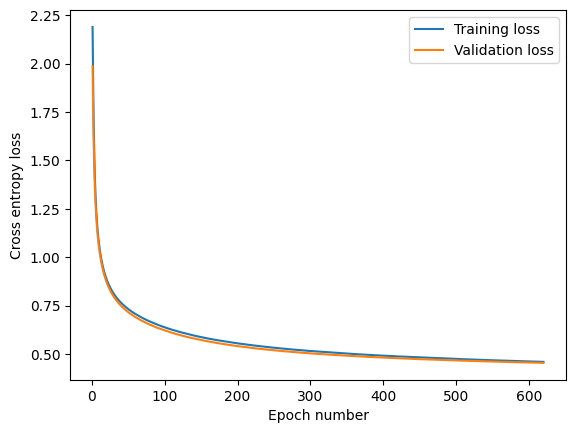

In [101]:
# See the training for the best white wine model
history = model3_white[-1].history
print("White wine")
fig, ax = plt.subplots()
ax.plot(np.arange(1,len(history)+1),history[:, 'train_loss'],label="Training loss");
ax.plot(np.arange(1,len(history)+1),history[:, 'valid_loss'],label="Validation loss");
ax.set_xlabel("Epoch number")
ax.set_ylabel("Cross entropy loss")
ax.legend();

Red wine


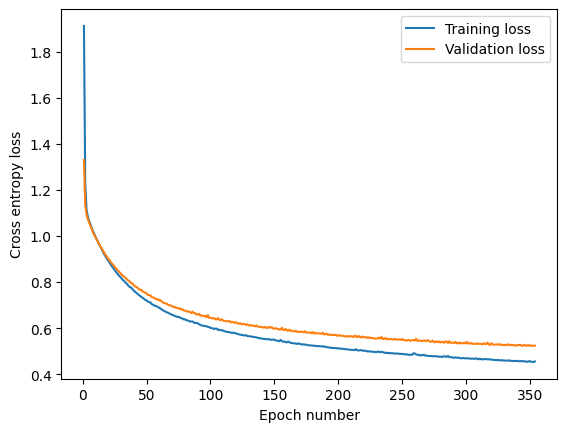

In [102]:
# See the training for the best white wine model
history = model3_red[-1].history
print("Red wine")
fig, ax = plt.subplots()
ax.plot(np.arange(1,len(history)+1),history[:, 'train_loss'],label="Training loss");
ax.plot(np.arange(1,len(history)+1),history[:, 'valid_loss'],label="Validation loss");
ax.set_xlabel("Epoch number")
ax.set_ylabel("Cross entropy loss")
ax.legend();

In [103]:
# Saving models
with open('model3_white.pkl', 'wb') as f:
    pickle.dump(model3_white, f)
with open('model3_red.pkl', 'wb') as f:
    pickle.dump(model3_red, f)

To see models' evaluation, go <a href=#Model-Evaluation> here</a>.

### ANN Regressor for ordinal classification

For regressor ANN, I will implement a similar architecture, the only difference being that the output layer will have only one neuron, as the output now is a quality score (or a real number that's going to tell us the quality score). The same hyperparameters will be tested as for ANN classifier. The only difference is in the preprocessing and postprocessing. Mean square error will be used as a loss function during training.

In [26]:
regressor = NNRegressor(
    ModuleRegressor,
    optimizer=torch.optim.Adam,
    criterion=nn.MSELoss,
    max_epochs=200,
    lr=0.001,
    iterator_train__shuffle=True,
    callbacks=[EarlyStopping,],
    callbacks__EarlyStopping__patience=5,
    batch_size=128,
    device=dev,
)
model4 = Pipeline([("scaler",RobustScaler()),
                ("data_augmentation",RandomOverSampler(random_state=7)),
                ("classifier",regressor),
                 ])

In [27]:
param_grid4 = [
   {'scaler' : Categorical([RobustScaler()]),
   'data_augmentation' : Categorical([RandomOverSampler(random_state=7)]),
   'data_augmentation__shrinkage' : Real(0.1,1.0),
   'classifier__lr': Real(1e-4, 1e-1, prior='log-uniform'),
   'classifier__batch_size': Integer(4,512, prior="log-uniform",base=2),
   'classifier__module__n_layers': Integer(2,5),
   'classifier__module__layer_width': Integer(64,512,prior="log-uniform",base=2),},
]

In [ ]:

hyperparam_opt4_red = BayesSearchCV(model4,search_spaces=param_grid4,random_state=7,cv=5,
                                    scoring=balanced_accuracy_regression_score)
hyperparam_opt4_white = BayesSearchCV(model4,search_spaces=param_grid4,random_state=7,cv=5,
                                    scoring=balanced_accuracy_regression_score)
hyperparam_opt4_red.fit(X_red_train.values,Y_red_train.values)
hyperparam_opt4_white.fit(X_white_train.values,Y_white_train.values)

In [66]:
# Check best hyperparameters
print(hyperparam_opt4_white.best_params_)
print(hyperparam_opt4_red.best_params_)

OrderedDict([('classifier__batch_size', 4), ('classifier__lr', 0.1), ('classifier__module__layer_width', 512), ('classifier__module__n_layers', 2), ('data_augmentation', RandomOverSampler(random_state=7)), ('data_augmentation__shrinkage', 1.0), ('scaler', RobustScaler())])
OrderedDict([('classifier__batch_size', 4), ('classifier__lr', 0.1), ('classifier__module__layer_width', 512), ('classifier__module__n_layers', 3), ('data_augmentation', RandomOverSampler(random_state=7)), ('data_augmentation__shrinkage', 0.9944579340971782), ('scaler', RobustScaler())])


In [ ]:
# Train further the best model with less strict early stopping
model4_red = hyperparam_opt4_red.best_estimator_
model4_white = hyperparam_opt4_white.best_estimator_
model4_red.set_params(classifier__max_epochs=500,classifier__callbacks=[EarlyStopping,LRScheduler(policy=ReduceLROnPlateau,patience=3)],
                      classifier__callbacks__EarlyStopping__patience=6, classifier__warm_start=True,classifier__lr=0.0005)
model4_white.set_params(classifier__max_epochs=500,classifier__callbacks=[EarlyStopping,LRScheduler(policy=ReduceLROnPlateau,patience=3)],
                      classifier__callbacks__EarlyStopping__patience=6, classifier__warm_start=True,classifier__lr=0.0005)
model4_red.fit(X_red_train.values,Y_red_train.values)
model4_white.fit(X_white_train.values,Y_white_train.values)

White wine


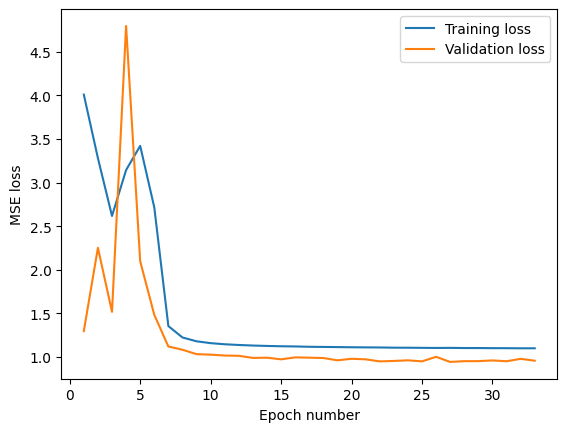

In [57]:
# See the training for the best white wine model
history = model4_white[-1].history
print("White wine")
fig, ax = plt.subplots()
ax.plot(np.arange(1,len(history)+1),history[:, 'train_loss'],label="Training loss");
ax.plot(np.arange(1,len(history)+1),history[:, 'valid_loss'],label="Validation loss");
ax.set_xlabel("Epoch number")
ax.set_ylabel("MSE loss")
ax.legend();

In [ ]:
# See the training for the best red wine model
history = model4_red[-1].history
print("Red wine")
fig, ax = plt.subplots()
ax.plot(np.arange(1,len(history)+1),history[:, 'train_loss'],label="Training loss");
ax.plot(np.arange(1,len(history)+1),history[:, 'valid_loss'],label="Validation loss");
ax.set_xlabel("Epoch number")
ax.set_ylabel("MSE loss")
ax.legend();

Notice that in the real world, sometimes learning curves are not perfect as the model struggles to learn the paterns from the training data and generalize to validation data. This instability in the learning process sometimes can be avoided using more advanced learning rate schedulers, some sophisticated neural network architectures and changing the optimizer. Still, there are cases when nothing can be done about it. I will not try to address this issue here, but the comment here is to simply acknowledge this fact.

In [60]:
# Saving models
with open('model4_white.pkl', 'wb') as f:
    pickle.dump(model4_white, f)
with open('model4_red.pkl', 'wb') as f:
    pickle.dump(model4_red, f)

## Model Evaluation

In [15]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

<div class="intro">
We should be careful when we evaluate models where the dataset is imbalanced. Accuracy is not a good metric in those cases. For instance, check the disitribution of classes in the training set(the distribution is the same as in the test set because we used strafified splitting). The model that would predict that any wine is a good wine would have the accuracy score of 0.8777 for red wines and 0.7795 for white wines. Those seem like a decent accuracy scores. However, model that always predicts that a wine is good is completely useless. Instead, we have to use a metric that takes the class imbalance into account. One general metric that does that is balanced accuracy score. There are many ways to generalize this metric for multilabel classification, and I will use the metric <a href="https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score"> as implemented in scikit-learn</a>. Confusion matrix is another useful metric for multilabel classification that also works well on imbalanced dataset and it will be discussed.
</div>

In [10]:
Y_label_red_train.groupby("quality_label")["quality_label"].count()/Y_label_red_train.groupby("quality_label")["quality_label"].count().sum()

quality_label
Excellent    0.136044
Good         0.857701
Poor         0.006255
Name: quality_label, dtype: float64

In [12]:
Y_label_white_train.groupby("quality_label")["quality_label"].count()/Y_label_white_train.groupby("quality_label")["quality_label"].count().sum()

quality_label
Excellent    0.216437
Good         0.779479
Poor         0.004084
Name: quality_label, dtype: float64

<div class="rqT" title="On model purpose and evaluation">
Depending on what the model is going to be used for, different accuracy metric can be more or less important. For a list of accuracy metrics and basic explanation about them consult the following <a href="https://en.wikipedia.org/wiki/Sensitivity_and_specificity"> resource</a>. I will give here two examples relevant for the wine classification.
    
1. Imagine that the model will be used as pre-screening for excellent wines, and the select wines are later going to be tested by sommelier. This means that we want to select all the excellent wines from the group. Selecting some good or even poor wines as excellent will not be a huge problem, as the wines are going to be tested again by sommeliers. However, if we score excellent wines as good or poor and discard them, that would be a big deal, because we threw away potential best wine. In this scenario, we want to minimize the miss rate, but we can tolerate higher fall-out rate. This scorers can be then used for hyperparameter optimization and for scoring models.
2. Now let's put the oposite scenario. We want to remove bad wines from the selection and buy the others for the restaurant and we don't have money to pay for sommeliers. In this case, we are okay with missing some excellent wines, as long as we don't select any bad wines for our restaurant. Now we are very interested in specificity, but we are not that eager to optimize sensitivity if that will lower the specificity. <br> <br>
Keep in mind that almost always optimizing one accuracy metric comes with the cost of making the other metrics worse. There is no free lunch, and we must carefully choose each step in the modeling based on our final goal. Apart from scoring and evaluation, the choice of cost function can also be influenced by the model purpose. In this work, we don't know the goal of our model, so I was using general metric that usually work well, but they are not optimal for any specific purpose.
</div>

### Logistic Regression for Ordinal Classification

#### White wines

Balanced accuracy score: 0.4211202212782772

Accuracy score: 0.5571428571428572



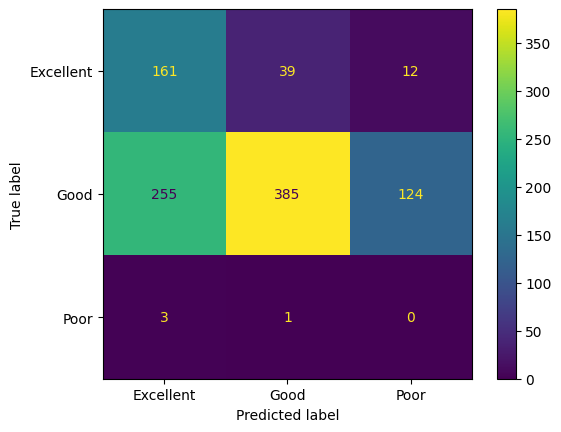

In [62]:
Y_1_white = model1_white.predict(X_white_test)
ConfusionMatrixDisplay.from_predictions(Y_label_white_test,Y_1_white);
print(f"Balanced accuracy score: {balanced_accuracy_score(Y_label_white_test,Y_1_white)}\n")
print(f"Accuracy score: {accuracy_score(Y_label_white_test,Y_1_white)}\n")

#### Red wines

Balanced accuracy score: 0.82331

Accuracy score: 0.66250



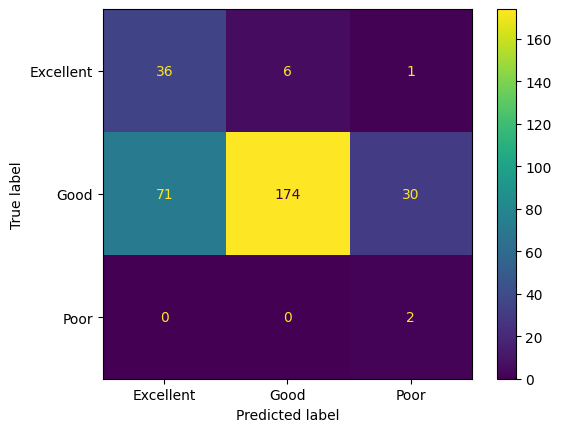

In [63]:
Y_1_red = model1_red.predict(X_red_test)
ConfusionMatrixDisplay.from_predictions(Y_label_red_test,Y_1_red);
print(f"Balanced accuracy score: {balanced_accuracy_score(Y_label_red_test,Y_1_red):.5f}\n")
print(f"Accuracy score: {accuracy_score(Y_label_red_test,Y_1_red):.5f}\n")

### Linear Regression for Ordinal Classification

#### White wines

Balanced accuracy score: 0.43409

Accuracy score: 0.78673



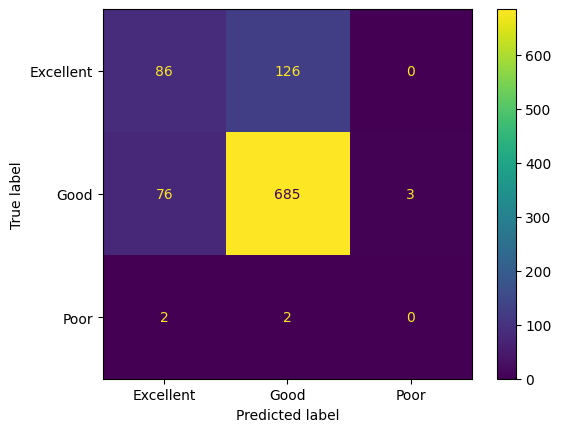

In [64]:
Y_2_white = model2_white.decision_function(X_white_test)
ConfusionMatrixDisplay.from_predictions(Y_label_white_test,Y_2_white);
print(f"Balanced accuracy score: {balanced_accuracy_score(Y_label_white_test,Y_2_white):.5f}\n")
print(f"Accuracy score: {accuracy_score(Y_label_white_test,Y_2_white):.5f}\n")

#### Red wines

Balanced accuracy score: 0.42610

Accuracy score: 0.86250



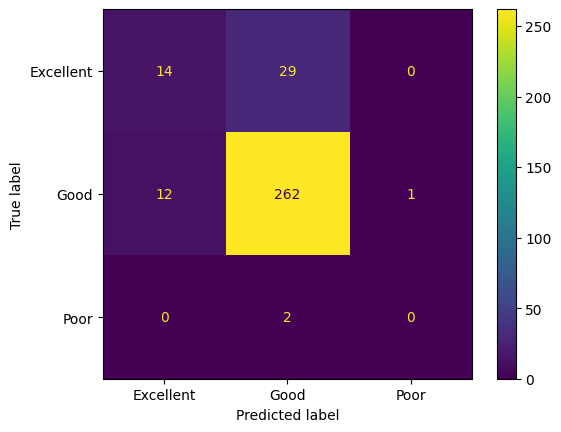

In [65]:
Y_2_red = model2_red.decision_function(X_red_test)
ConfusionMatrixDisplay.from_predictions(Y_label_red_test,Y_2_red,labels=["Excellent","Good","Poor"]);
print(f"Balanced accuracy score: {balanced_accuracy_score(Y_label_red_test,Y_2_red):.5f}\n")
print(f"Accuracy score: {accuracy_score(Y_label_red_test,Y_2_red):.5f}\n")

### ANN Softmax Classifier for Ordinal Classification

#### White wines

Balanced accuracy score: 0.4725048569264711

Accuracy score: 0.6959183673469388



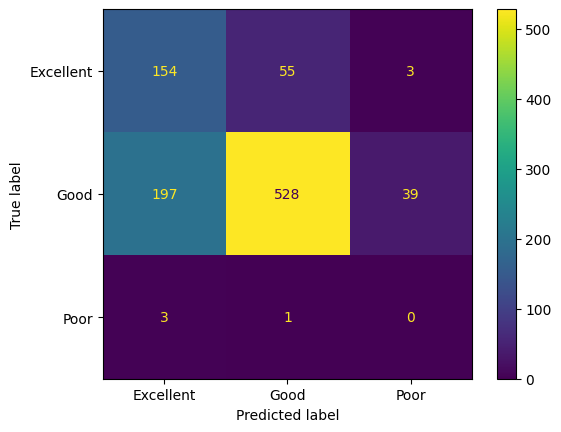

In [66]:
Y_3_white = model3_white.decision_function(X_white_test)
ConfusionMatrixDisplay.from_predictions(Y_label_white_test,Y_3_white);
print(f"Balanced accuracy score: {balanced_accuracy_score(Y_label_white_test,Y_3_white)}\n")
print(f"Accuracy score: {accuracy_score(Y_label_white_test,Y_3_white)}\n")

#### Red wines

Balanced accuracy score: 0.834954193093728

Accuracy score: 0.709375



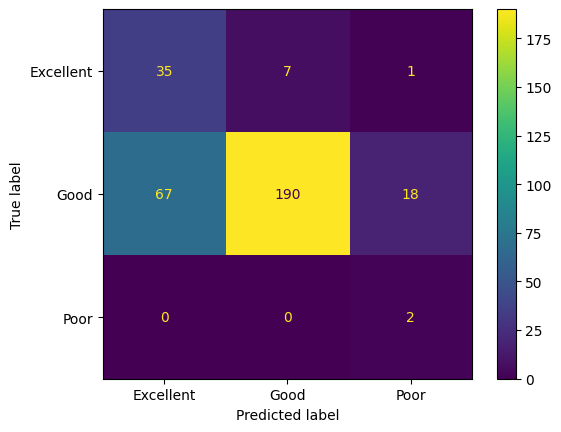

In [67]:
Y_3_red = model3_red.decision_function(X_red_test)
ConfusionMatrixDisplay.from_predictions(Y_label_red_test,Y_3_red);
print(f"Balanced accuracy score: {balanced_accuracy_score(Y_label_red_test,Y_3_red)}\n")
print(f"Accuracy score: {accuracy_score(Y_label_red_test,Y_3_red)}\n")

### ANN Regressor for Ordinal Classification

#### White wines

Balanced accuracy score: 0.47525

Accuracy score: 0.78469



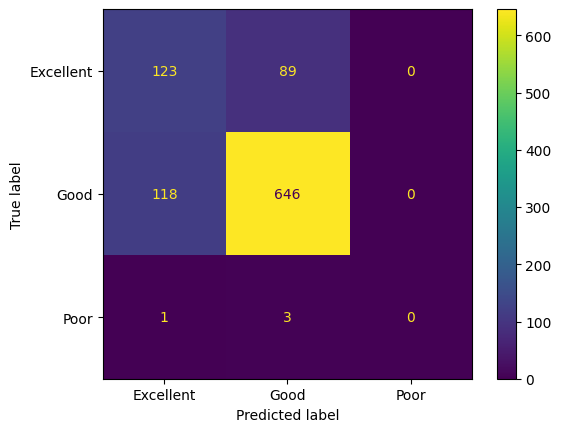

In [68]:
Y_4_white = model4_white.decision_function(X_white_test.values)
ConfusionMatrixDisplay.from_predictions(Y_label_white_test,Y_4_white);
print(f"Balanced accuracy score: {balanced_accuracy_score(Y_label_white_test,Y_4_white):.5f}\n")
print(f"Accuracy score: {accuracy_score(Y_label_white_test,Y_4_white):.5f}\n")

#### Red wines

Balanced accuracy score: 0.445722339675828

Accuracy score: 0.8625



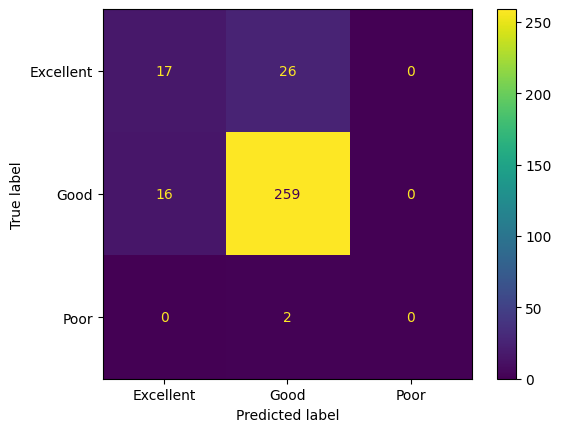

In [69]:
Y_4_red = model4_red.decision_function(X_red_test.values)
ConfusionMatrixDisplay.from_predictions(Y_label_red_test,Y_4_red);
print(f"Balanced accuracy score: {balanced_accuracy_score(Y_label_red_test,Y_4_red)}\n")
print(f"Accuracy score: {accuracy_score(Y_label_red_test,Y_4_red)}\n")

### Discussion of Model Evaluation

<div class="rqT" title="The deadly sin of ML modelling - data leakage">
Before the dicussion of the models I built, I have to point out the big problem I found in the <a href="https://github.com/kmspitzer/final-wineproject"> wine project repository</a>. They have commit three serious errors that result in data leakage from training into test set. This means their model evaluation is completely wrong and their scores are higher and they overestimate performance of the models.

1. They scaled the data before test-train split. This results in the leakage of possible feature values ranges from the test set into training set.
2. They perfomed data augmenation before test-train split. This also leaks information from the test set, as it might happen that the artifical data points that are generated from the point in one set end up in the other set. This is very serious issue, as it affects the results drastically!
3. They performed the model evaluation using artifically generated data from data augmantation.
   
The main conlcustion is that **the test-training split has to be done BEFORE any preprocessing to avoid data leakage**.
</div>

<div class="intro">
Confusion matrix gives a lot of information about model performance. In fact, all accuracy metrics can be calculated from confusion matrix. However, for each model I will only focus on the points I find interesting for that model or the points that are the strong or weak side of the model. Some metrics I want to discuss and how they are related to confusion matrix elements
    
* Accuracy score - sum of the elements in the main diagonal
* Serious error cases -  elements in the upper-right and lower-left corner
</div>

#### Logistic Regression for Ordinal Classification

The only good thing about this model is the fact that most of the excellent wines are indeed classified as excellent (sensitivity for excellent wines is relatively high).
All the other possible metrics are bad and the model is not that useful. For instance, if the model predicts that the wine is excellent, chances of wine indeed being excellent are less than 50%. Also 15 white wines are classified with serious error. Also notice that there are no wines that are correctly predicted as poor for white wines. On the other hand, both poor red wines are correctly classified as poor. Only one red wines is seriously missclassified.

#### Linear Regression for Ordinal Classification

This model performs better, as there are only 2 white wines seriously missclassified, and no red wine is seriously missclassified. Now the changes of wine being excellent when classified as excellent is higher than 50%. However, it performes worse when we consider that now most of the truly excellent wines are classified as good, and that no wines are classified as poor are indeed poor. Still, most of the good wines are now classified correctly.

#### ANN Classifier for Ordinal Classification

The same trend happens here. Softmax classification does a good job in finding the excellent wines (most of the excellent wines are classified as excellent). However, still the probability of wine classified as excellent being excellent is smaller than 50%. In other words, the softmax classifiers have relatively good sensitivity and bad precision when we are talking about excellent wines. It lowered the amount of seriously missclassified wines compared to its linear analog. Both red wines of poor quality are classified as such, but it also fails to classify poor white wines.

#### ANN Regressor for Ordinal Classification


We can see the same trend again. Regeressor does much better job regarding serious missclassifications, and the accuracy in general. Its sensitivity and precision with respect to excellent white wines are the best. However, the sensitivity is barely 50% with respect to excellent red wines, and it has very bad precision. Moreover, it doesn't classify any poor white or red wine correctly.

## Conclusions

<div class="intro">

In general, the models are not performing well enough for general real life application. Some models do relatively good job for particular wines, such as ANN regressor for white wines. However, I would say that in general, even if we would use more advanced techniques, such as dropout layers, learning rate schedulers, and deeper neural networks, we would not achive performance that would satisfy real life needs. The key for this is the nature of the problem itself: We are trying to classify wines based on only 11 **very simple** physicochemical descriptors. The wine quality depends on many factors and even extremely low concetrations of very specific compounds can alter the taste. Furthermore, wine quality can also depend on the smell, color, viscosity etc. and those can also be affected by compounds that are not easily described using these 11 descriptors. Finally, wine scoring is done by humans, so the noise is also introduced beacuse people can never be 100% objective. We can not expect that this 11 features from this dataset carry enough information to predict the wine quality. <br> <br>

We also saw that the ANN perform slighly better than the linear analog models. However, taking into account how expensive they are to train, they didn't justify additional cost of training. Especially in the cases where the data is not expressive enough and there are no complex relations that can be captures, the linear models perform reasonably well. We also noticed that for the ordinal classifications like this, both softmax classifiers and regressors have their pros and cons. Of course, better performance could be expected using better loses in case of regressors or better encoding that captures order of classes in case of softmax classifiers, but I highly doubt we would see significant improvement, simply because the features present in the dataset are not descriptive enough. In the end we always come back to the most famous phylosophy of machine learning and data science: garbage-in-garbage-out. No model can capture the patern in the data if the patern is not there (or features don't carry it). It's always better to improve the quality and size of the dataset rather than trying to improve the model using fancy and advanced algorithms.
</div>

In [ ]:
vID.end(cwd0)